In [2]:
# import pandas as pd
# import numpy as np
# from fbprophet import Prophet
# import matplotlib.pyplot as plt
# import tushare as ts


# de=ts.get_hist_data('002230',start='2017-01-01',end='2019-12-31')

# df=pd.DataFrame()

# df['y']=de['open']
# df['ds']=list(de.index)

# # 定义模型
# m = Prophet()

# # 训练模型
# m.fit(df)

# # 构建预测集
# future = m.make_future_dataframe(periods=60)
# print (future.tail())

# # 进行预测
# forecast = m.predict(future)

# m.plot(forecast)
# plt.show()


In [80]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas_datareader as pdr
from matplotlib import font_manager as fm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from plotly import tools
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [81]:
import lightgbm as lgb
from sklearn import svm, datasets
import gc
from time import time
from datetime import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
plt.style.use('fivethirtyeight') 
import os, sys, gc, warnings, random
from catboost import CatBoostClassifier, Pool, cv

/Users/cheriehe/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [3]:
#pip install baostock -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn

## 用baostock获取A股数据

### 登录
login()
方法说明：登录系统。

使用示例：lg = login()

返回信息：

lg.error_code：错误代码，当为“0”时表示成功，当为非0时表示失败；
lg.error_msg：错误信息，对错误的详细解释。
### 登出
logout()
方法说明：登出系统

使用示例：lg = logout()

返回信息：

lg.error_code：错误代码，当为“0”时表示成功，当为非0时表示失败；
lg.error_msg：错误信息，对错误的详细解释

### 获取历史A股K线数据
获取历史A股K线数据：query_history_k_data_plus()
方法说明：通过API接口获取A股历史交易数据（包括均线数据），可以通过参数设置获取日k线、周k线、月k线，以及5分钟、15分钟、30分钟和60分钟k线数据，适合搭配均线数据进行选股和分析。

返回类型：pandas的DataFrame类型。

能获取2006-01-01至当前时间的数据；

可查询不复权、前复权、后复权数据。

In [4]:
def get_stocks_data(stkname, code):    
    import baostock as bs

    #### 登陆系统 ####
    lg = bs.login()
    # 显示登陆返回信息
    print('login respond error_code:'+lg.error_code)
    print('login respond  error_msg:'+lg.error_msg)

    #### 获取历史K线数据 ####
    # 详细指标参数，参见“历史行情指标参数”章节
#     stkname = ["sz.002230", "sz.399905",'sz.002680']
    rs = []
    #### 打印结果集 ####
    data_list = []
    for i in range(len(code)):
        rs = bs.query_history_k_data_plus(code[i],
            "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST",
            start_date='2019-01-01', end_date='2020-01-21', frequency="d", adjustflag="3") #frequency="d"取日k线，adjustflag="3"默认不复权

        while (rs.error_code == '0') & rs.next():
            # 获取一条记录，将记录合并在一起
            data_list.append(rs.get_row_data())
        result = pd.DataFrame(data_list, columns=rs.fields)
        #### 结果集输出到csv文件 ####
    filename = f'{stkname}_stocks_data.csv'
    result.to_csv(filename, encoding="gbk", index=False)
#     print(result)
    print('query_history_k_data_plus respond error_code:'+rs.error_code)
    print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)
    return result

    #### 登出系统 ####
    bs.logout()

In [64]:
# get_stocks_data('上证指数',['sh.000001'])
sz300 = pd.read_csv('上证指数_stocks_data.csv', index_col='date', parse_dates=['date'])
sz300.head()

,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST
date,,,,,,,,,,,,,,,,,
2019-01-02,sh.000001,2497.880,2500.278,2456.423,2465.291,2493.896,10993201408,9.759257e+10,3,0.328717,1,-1.1470,0.0,0.0,0.0,0.0,0
2019-01-03,sh.000001,2461.782,2488.479,2455.925,2464.362,2465.291,12439749632,1.069228e+11,3,0.371963,1,-0.0377,0.0,0.0,0.0,0.0,0
2019-01-04,sh.000001,2446.019,2515.316,2440.906,2514.868,2464.362,16887766784,1.392987e+11,3,0.504935,1,2.0494,0.0,0.0,0.0,0.0,0
2019-01-07,sh.000001,2528.698,2536.977,2515.508,2533.088,2514.868,17730501120,1.455132e+11,3,0.530082,1,0.7245,0.0,0.0,0.0,0.0,0
2019-01-08,sh.000001,2530.300,2531.345,2520.164,2526.462,2533.088,15809918208,1.233790e+11,3,0.472663,1,-0.2616,0.0,0.0,0.0,0.0,0


In [65]:
# get_stocks_data('kdxf', ['sz.002230'])
result = pd.read_csv('kdxf_stocks_data.csv', index_col='date', parse_dates=['date'])
result.head()

,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST
date,,,,,,,,,,,,,,,,,
2019-01-02,sz.002230,24.63,25.35,24.61,25.04,24.64,32894190,8.256631e+08,3,1.805117,1,1.623383,107.999223,6.832481,7.137286,-67.064552,0
2019-01-03,sz.002230,24.98,25.85,24.88,25.44,25.04,41748458,1.061824e+09,3,2.291008,1,1.597443,109.724451,6.941626,7.251300,-68.135871,0
2019-01-04,sz.002230,25.16,27.46,25.01,27.13,25.44,68481699,1.806189e+09,3,3.758034,1,6.643076,117.013536,7.402764,7.733009,-72.662192,0
2019-01-07,sz.002230,27.49,29.58,27.20,29.27,27.13,81114177,2.326280e+09,3,4.451259,1,7.887952,126.243501,7.986690,8.342985,-78.393748,0
2019-01-08,sz.002230,29.39,29.88,28.60,29.02,29.27,57752434,1.679223e+09,3,3.169249,1,-0.854117,125.165234,7.918474,8.271726,-77.724173,0


In [66]:
kdxf = result
del kdxf['adjustflag']
del kdxf['isST']
del kdxf['tradestatus']

In [67]:
kdxf = pd.merge(kdxf,sz300['close'],left_index=True,right_index=True)
# kdxf['close'] = kdxf['close_x']
# kdxf['close_sz300'] = kdxf['close_y']
# del kdxf['close_y'] 
# del kdxf['close_x']

kdxf.head(3)

,code,open,high,low,close_x,preclose,volume,amount,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_y
date,,,,,,,,,,,,,,,
2019-01-02,sz.002230,24.63,25.35,24.61,25.04,24.64,32894190,8.256631e+08,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291
2019-01-03,sz.002230,24.98,25.85,24.88,25.44,25.04,41748458,1.061824e+09,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362
2019-01-04,sz.002230,25.16,27.46,25.01,27.13,25.44,68481699,1.806189e+09,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868


In [68]:
kdxf.columns=['code','open','high','low','close','preclose','volume','amount','turn','pctChg','peTTM','pbMRQ','psTTM','pcfNcfTTM','close_sz300']
kdxf.head()

,code,open,high,low,close,preclose,volume,amount,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300
date,,,,,,,,,,,,,,,
2019-01-02,sz.002230,24.63,25.35,24.61,25.04,24.64,32894190,8.256631e+08,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291
2019-01-03,sz.002230,24.98,25.85,24.88,25.44,25.04,41748458,1.061824e+09,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362
2019-01-04,sz.002230,25.16,27.46,25.01,27.13,25.44,68481699,1.806189e+09,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868
2019-01-07,sz.002230,27.49,29.58,27.20,29.27,27.13,81114177,2.326280e+09,4.451259,7.887952,126.243501,7.986690,8.342985,-78.393748,2533.088
2019-01-08,sz.002230,29.39,29.88,28.60,29.02,29.27,57752434,1.679223e+09,3.169249,-0.854117,125.165234,7.918474,8.271726,-77.724173,2526.462


In [69]:
kdxf['withoutsz300'] = kdxf['close'] - kdxf['close_sz300']/kdxf['close_sz300'].mean()*kdxf['close'].mean()

In [85]:
kdxf['date'] = kdxf.index
# del kdxf['code']
# del kdxf['open']
# del kdxf['low']
# del kdxf['high']
del kdxf['preclose']
kdxf.head(3)

,close,volume,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,date,attention
date,,,,,,,,,,,,
2019-01-02,25.04,32894190,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,2019-01-02,105
2019-01-03,25.44,41748458,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,2019-01-03,107
2019-01-04,27.13,68481699,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,2019-01-04,142


In [95]:
kdxf.to_csv('mkt_data.csv',index=False)

参数含义：

- code：股票代码，sh或sz.+6位数字代码，或者指数代码，如：sh.601398。sh：上海；sz：深圳。此参数不可为空；
- fields：指示简称，支持多指标输入，以半角逗号分隔，填写内容作为返回类型的列。详细指标列表见历史行情指标参数章节，日线与分钟线参数不同。此参数不可为空；
- start：开始日期（包含），格式“YYYY-MM-DD”，为空时取2015-01-01；
- end：结束日期（包含），格式“YYYY-MM-DD”，为空时取最近一个交易日；
- frequency：数据类型，默认为d，日k线；d=日k线、w=周、m=月、5=5分钟、15=15分钟、30=30分钟、60=60分钟k线数据，不区分大小写；指数没有分钟线数据；周线每周最后一个交易日才可以获取，月线每月最后一个交易日才可以获取。


In [72]:
kdxf.isnull().any()

code            False
open            False
high            False
low             False
close           False
preclose        False
volume          False
amount          False
turn            False
pctChg          False
peTTM           False
pbMRQ           False
psTTM           False
pcfNcfTTM       False
close_sz300     False
withoutsz300    False
date            False
dtype: bool

In [73]:
kdxf.count()

code            258
open            258
high            258
low             258
close           258
preclose        258
volume          258
amount          258
turn            258
pctChg          258
peTTM           258
pbMRQ           258
psTTM           258
pcfNcfTTM       258
close_sz300     258
withoutsz300    258
date            258
dtype: int64

In [74]:
kdxf.shape

(258, 17)

In [15]:
kdxf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 258 entries, 2019-01-02 to 2020-01-21
Data columns (total 16 columns):
code            258 non-null object
open            258 non-null float64
high            258 non-null float64
low             258 non-null float64
close           258 non-null float64
preclose        258 non-null float64
volume          258 non-null int64
amount          258 non-null float64
turn            258 non-null float64
pctChg          258 non-null float64
peTTM           258 non-null float64
pbMRQ           258 non-null float64
psTTM           258 non-null float64
pcfNcfTTM       258 non-null float64
close_sz300     258 non-null float64
withoutsz300    258 non-null float64
dtypes: float64(14), int64(1), object(1)
memory usage: 44.3+ KB


In [16]:
spdate = datetime(2018,1,1)
spdate = str(spdate.date())
spdate

'2018-01-01'

### time series plot

In [77]:
# -*- coding: utf-8 -*-
# plot_data = kdxf.loc['2018':'2020']
def stock_plot(plot_df, name,col_name):
    my_font = fm.FontProperties(fname="PingFang.ttc")
    plot_data = plot_df[col_name]
    plot_data.plot(subplots=True, figsize=(18,18))
#     plot_data.plot(figsize=(16,20))
    plt.title(f'{name}股票价格数据时间序列图', fontproperties=my_font, size =22)
    sns.despine()
    plt.savefig(f'{col_name}stocks.png')
    # plt.show()
    # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
    plt.show()

In [78]:
col_name = ['close','close_sz300','amount','pctChg','withoutsz300','abs_pctchg','attention']

In [79]:
stock_plot(kdxf, '科大讯飞',col_name)

NameError: name 'fm' is not defined

In [94]:
# kdxf['upordown'] = None
upordown = []
for pct in kdxf['pctChg']:
    if pct>0:
        upordown.append('1')
    else:
        upordown.append('-1')
        
kdxf['upordown'] = upordown
kdxf.head(3)

,close,volume,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,date,attention,upordown
date,,,,,,,,,,,,,
2019-01-02,25.04,32894190,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,2019-01-02,105,1
2019-01-03,25.44,41748458,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,2019-01-03,107,1
2019-01-04,27.13,68481699,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,2019-01-04,142,1


In [31]:
# mkt_data = kdxf[['close', 'turn', 'pctChg','attention','upordown','close_sz300','psTTM','pcfNcfTTM']]
# mkt_data.to_csv('market_data.csv')
mkt_data = pd.read_csv('market_data.csv')
mkt_data.head()

,date,close,turn,pctChg,attention,upordown,close_sz300,psTTM,pcfNcfTTM
0,2019-01-02,25.04,1.805117,1.623383,106,1,2465.291,7.137286,-67.064552
1,2019-01-03,25.44,2.291008,1.597443,107,1,2464.362,7.251300,-68.135871
2,2019-01-04,27.13,3.758034,6.643076,142,1,2514.868,7.733009,-72.662192
3,2019-01-07,29.27,4.451259,7.887952,268,1,2533.088,8.342985,-78.393748
4,2019-01-08,29.02,3.169249,-0.854117,194,-1,2526.462,8.271726,-77.724173


In [32]:
# kdxf['upordown'] = None
import math
abschg = []
for pct in kdxf['pctChg']:
    if pct>0:
        abschg.append(pct)
    else:
        abschg.append(math.fabs(pct))
        
kdxf['abs_pctchg'] = abschg
kdxf.head(3)

,code,open,high,low,close,preclose,volume,amount,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,upordown,abs_pctchg
date,,,,,,,,,,,,,,,,,,
2019-01-02,sz.002230,24.63,25.35,24.61,25.04,24.64,32894190,8.256631e+08,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,1,1.623383
2019-01-03,sz.002230,24.98,25.85,24.88,25.44,25.04,41748458,1.061824e+09,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,1,1.597443
2019-01-04,sz.002230,25.16,27.46,25.01,27.13,25.44,68481699,1.806189e+09,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,1,6.643076


In [ ]:
sns.pairplot(kdxf[['close', 'volume', 'amount', 'turn', 'pctChg','attention']], hue='upordown', size=2.5)
plt.show()

_volume_ and *turn* have a complete linear relationship, we can't keep both
*volume* and *amount* also have a strong linear pattern, also we have to choose one
since the *turn* has the smallest number, I decide to keep this feature

In [ ]:
data = kdxf[['close','turn', 'pctChg','attention','upordown','close_sz300','pbMRQ','pcfNcfTTM']]

In [ ]:
sns.pairplot(data, hue='upordown', size=2.5)
plt.show()

In [ ]:
corrmat = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9,cmap="YlGnBu",annot=True)

In [21]:
kdxf_close = kdxf[['close']]
# kdxf_close.index = kdxf['date']
# kdxf_close

kdxf_close.head()

,close
date,
2019-01-02,25.04
2019-01-03,25.44
2019-01-04,27.13
2019-01-07,29.27
2019-01-08,29.02


In [22]:
def plot_diff(df):
    sns.set(style='ticks', context='poster')
    my_font = fm.FontProperties(fname="PingFang.ttc")
    kdxf_close = df[['close']]
    kdxf_close['diff_1'] = kdxf_close['close'].diff(1)

    kdxf_close['diff_2'] = kdxf_close['diff_1'].diff(1)

    # kdxf_close['diff_3'] = kdxf_close['diff_2'].diff(1)

    # kdxf_close['diff_4'] = kdxf_close['diff_3'].diff(1)

    kdxf_close.plot(subplots=True, figsize=(16, 20))

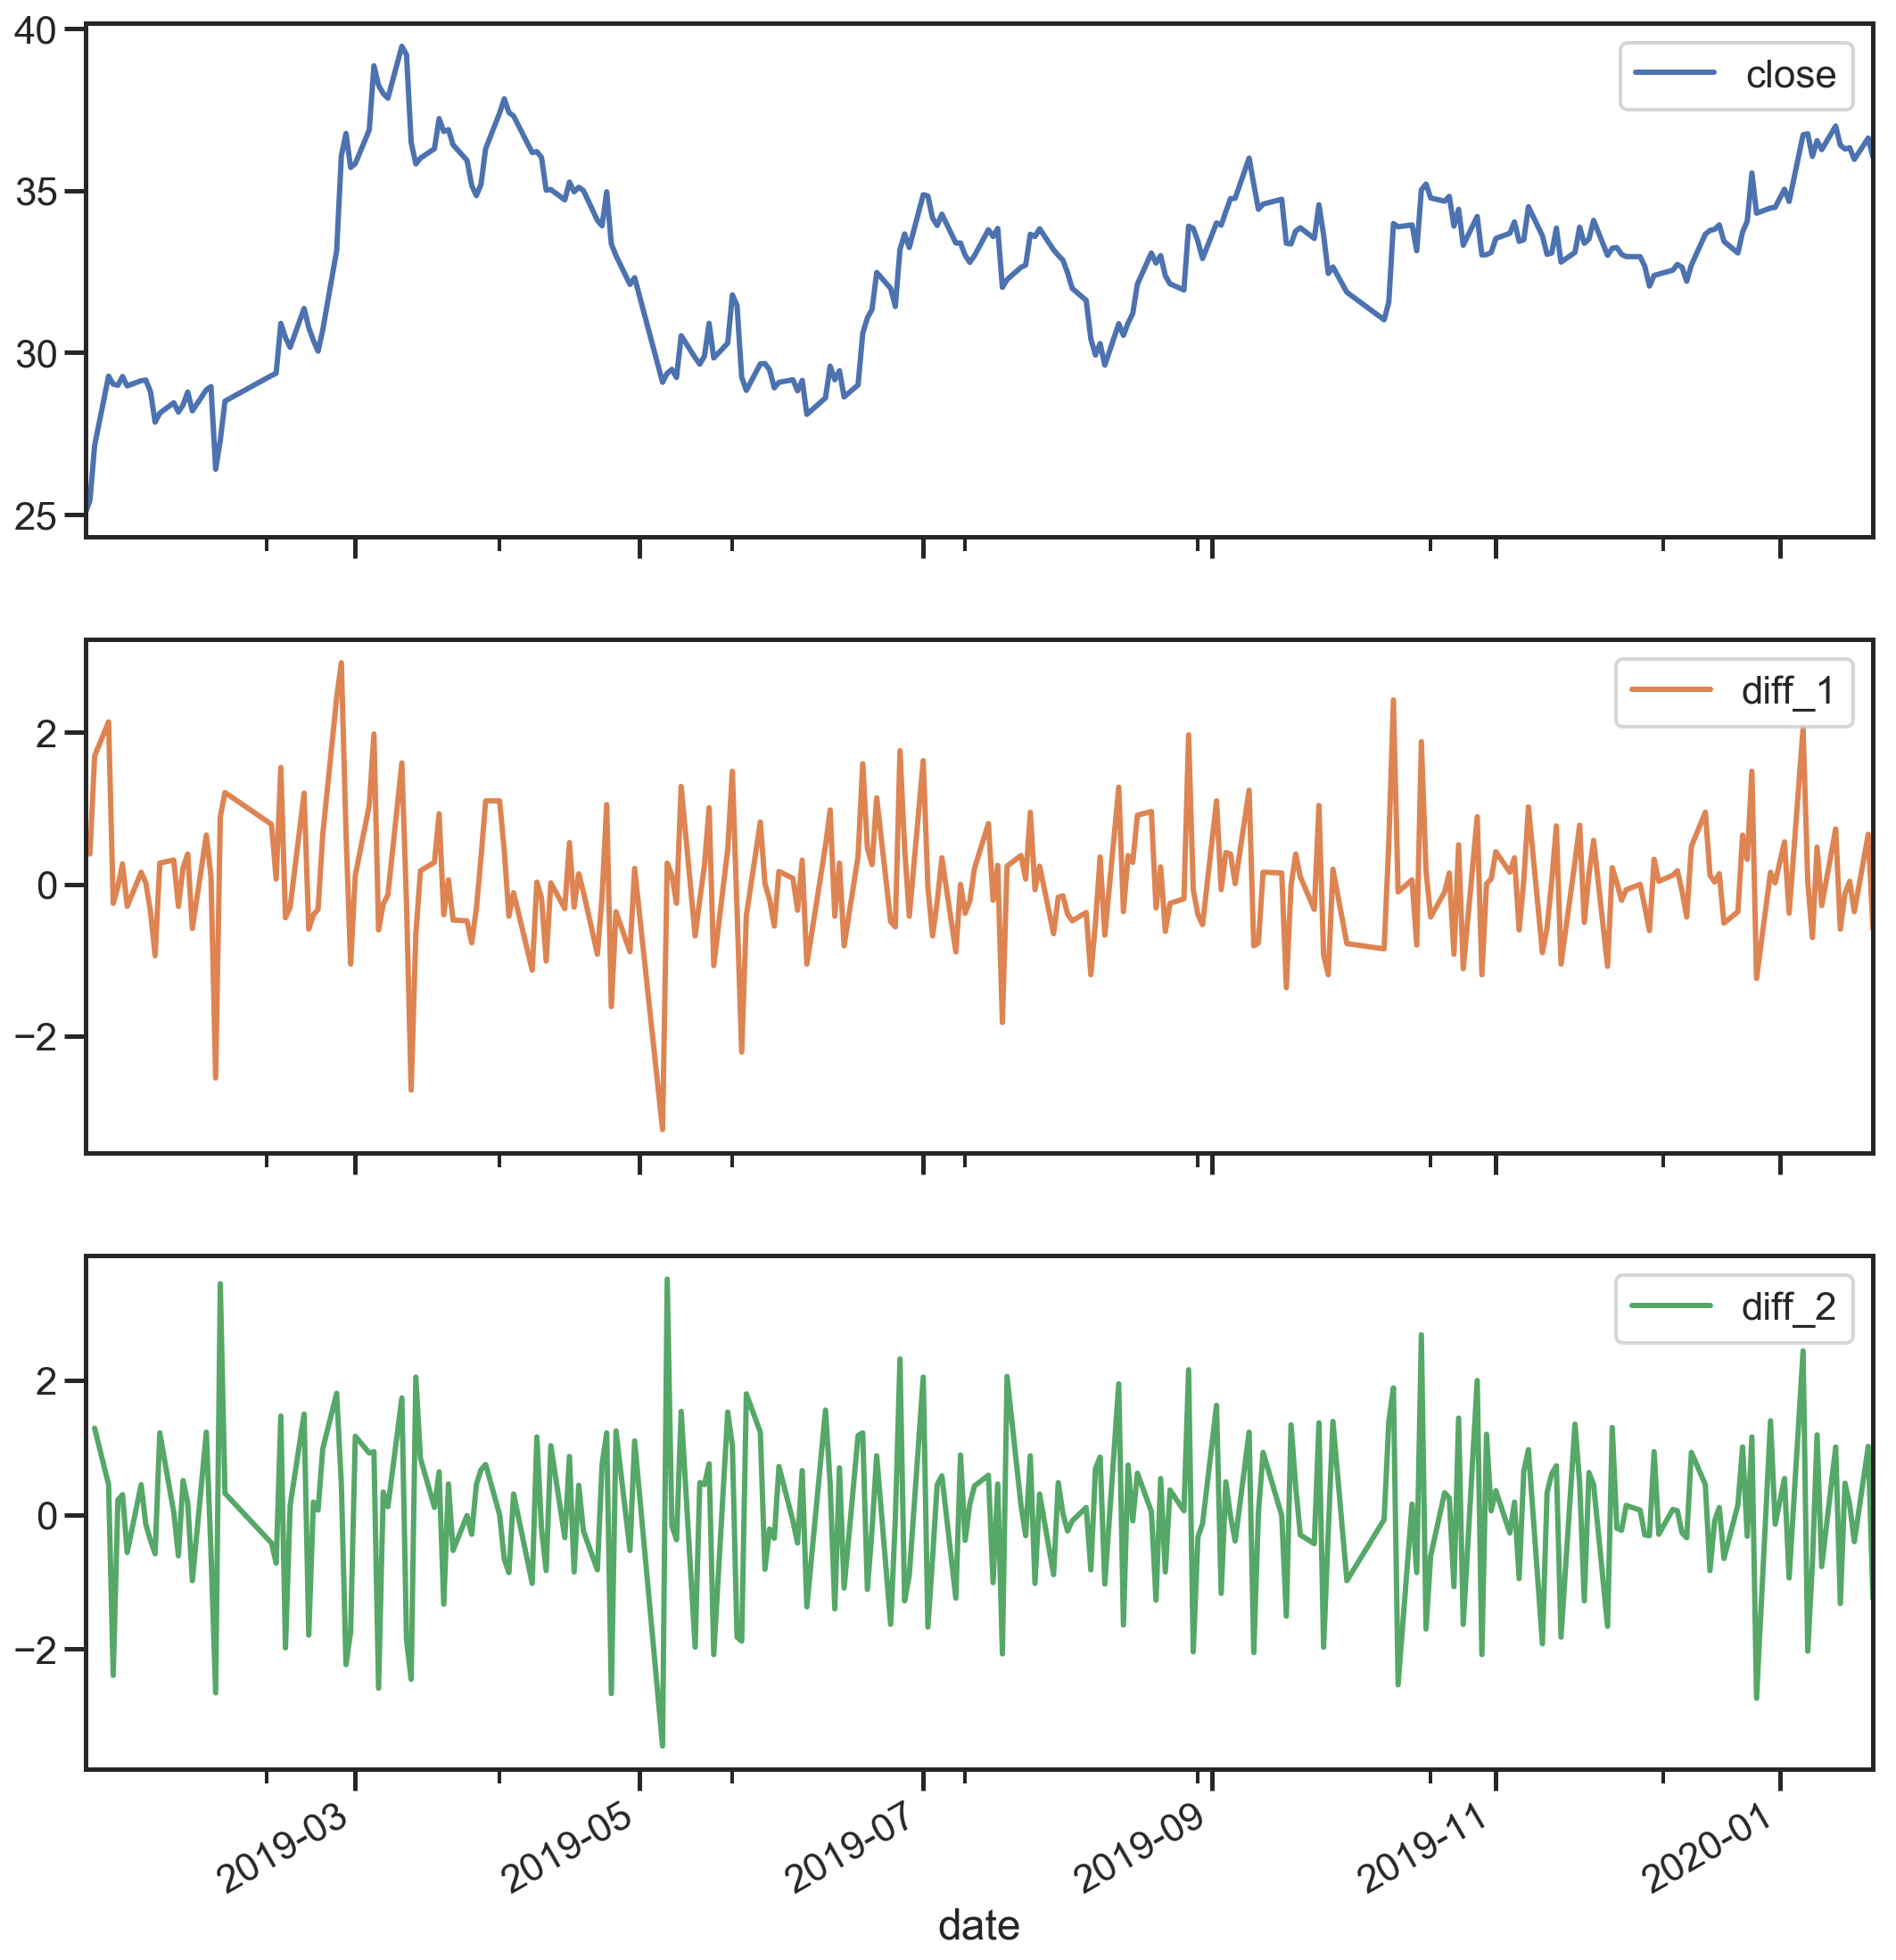

In [23]:
plot_diff(kdxf)

In [24]:
def acf_plot(df):
    sns.set(style='ticks', context='poster')
    fig = plt.figure(figsize=(12,8))

    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df, lags=20,ax=ax1)
    ax1.xaxis.set_ticks_position('bottom')
    fig.tight_layout();

    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df, lags=20, ax=ax2)
    ax2.xaxis.set_ticks_position('bottom')
    fig.tight_layout();
    # Partial Autocorrelation of closing price of kdxf stocks

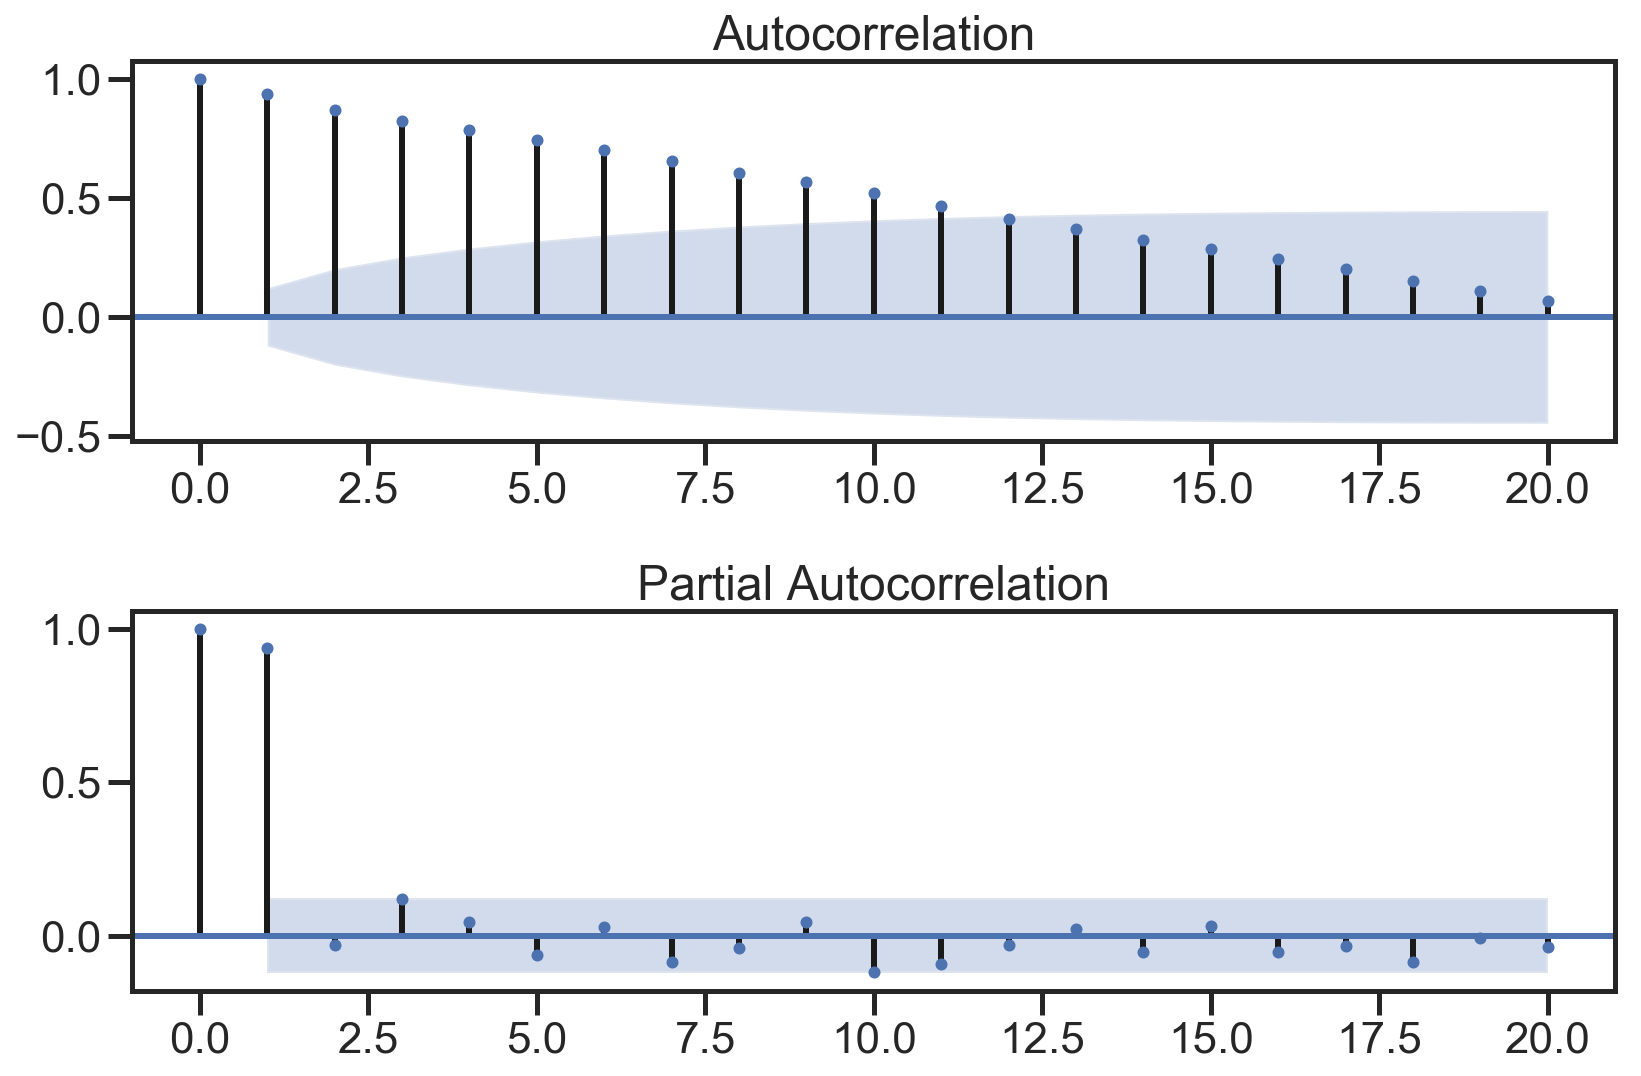

In [25]:
acf_plot(kdxf[['close']])

In [26]:
# 散点图也可以表示
def scater_stplt(df):
    lags=9

    ncols=3
    nrows=int(np.ceil(lags/ncols))
    sns.set(style='ticks', context='poster')
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    kdxf_close = df[['close']]
#     kdxf_close['diff_1'] = kdxf_close['close'].diff(1)
#     kdxf_close['diff_2'] = kdxf_close['diff_1'].diff(1)
    for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
        lag_str = 't-{}'.format(lag)
        X = (pd.concat([kdxf_close, kdxf_close.shift(-lag)], axis=1,
                       keys=['y'] + [lag_str]).dropna())

        X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
        corr = X.corr().as_matrix()[0][1]
        ax.set_ylabel('Original')
        ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
        ax.set_aspect('equal');
        sns.despine();

    fig.tight_layout();

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

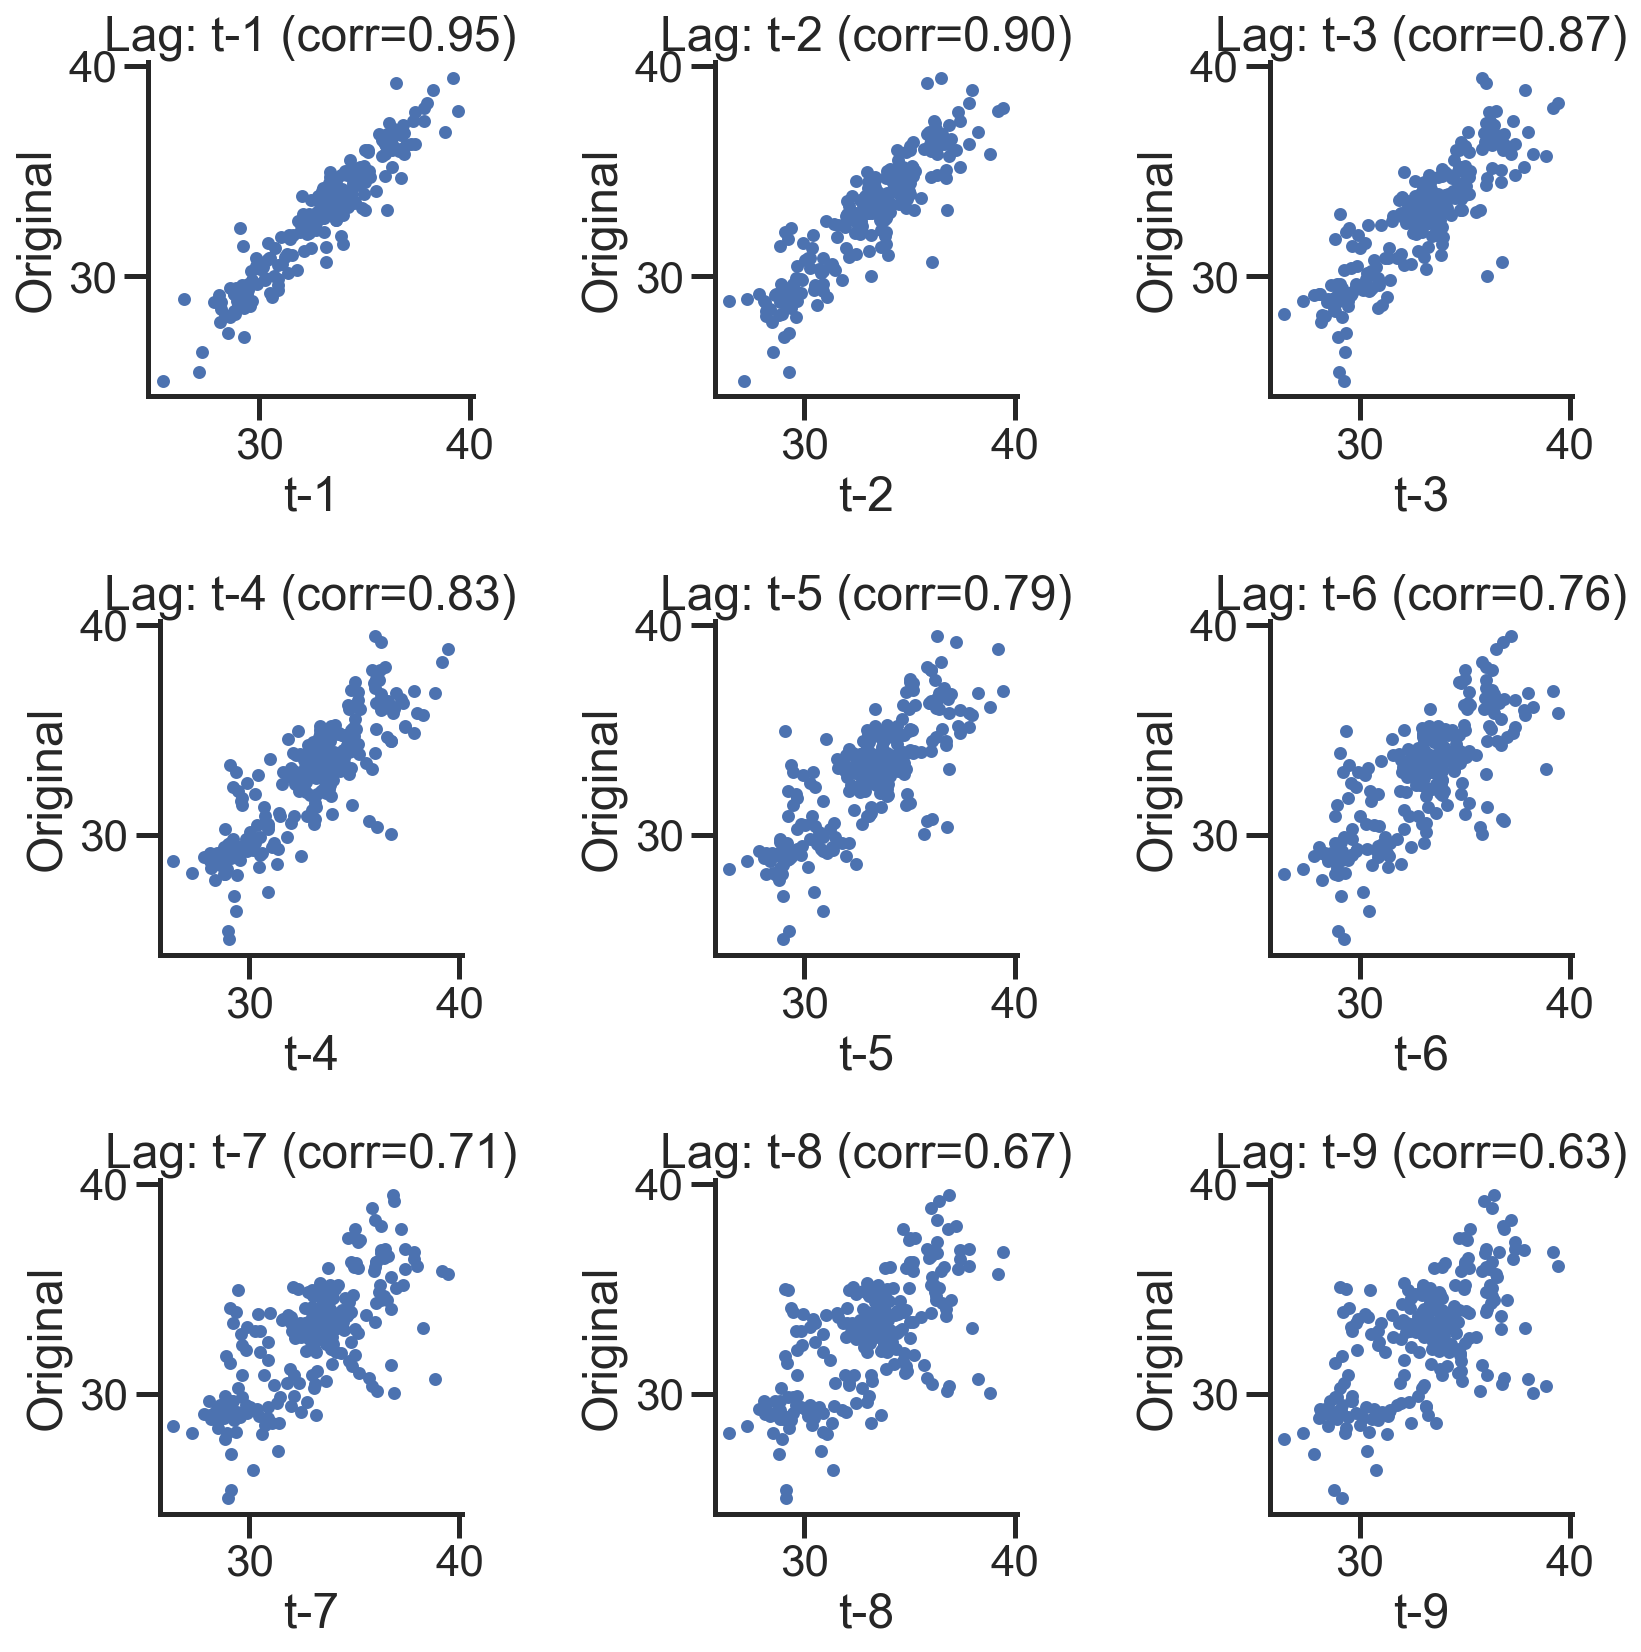

In [27]:
scater_stplt(kdxf)

### ARIMA models
An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

ARIMA(1,0,0)<br>

$y_t = a_1y_{t-1} + ϵ_t$

ARIMA(1,0,1)<br>
$y_t = a_1y_{t-1} + ϵ_t + b_1ϵ_{t-1}$

ARIMA(1,1,1)<br>
$Δy_t = a_1Δy_{t-1} + ϵ_t + b_1ϵ_{t-1}$  <br>where $Δy_t = y_t - y_{t-1}$

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  256
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -374.574
Method:                       css-mle   S.D. of innovations              1.045
Date:                Thu, 02 Apr 2020   AIC                            755.147
Time:                        19:54:55   BIC                            765.783
Sample:                             1   HQIC                           759.425
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.045     -0.087      0.931      -0.093       0.085
ar.L1.D.y     -0.4462      0.056     -7.963      0.000      -0.556      -0.336
                                    Roots           

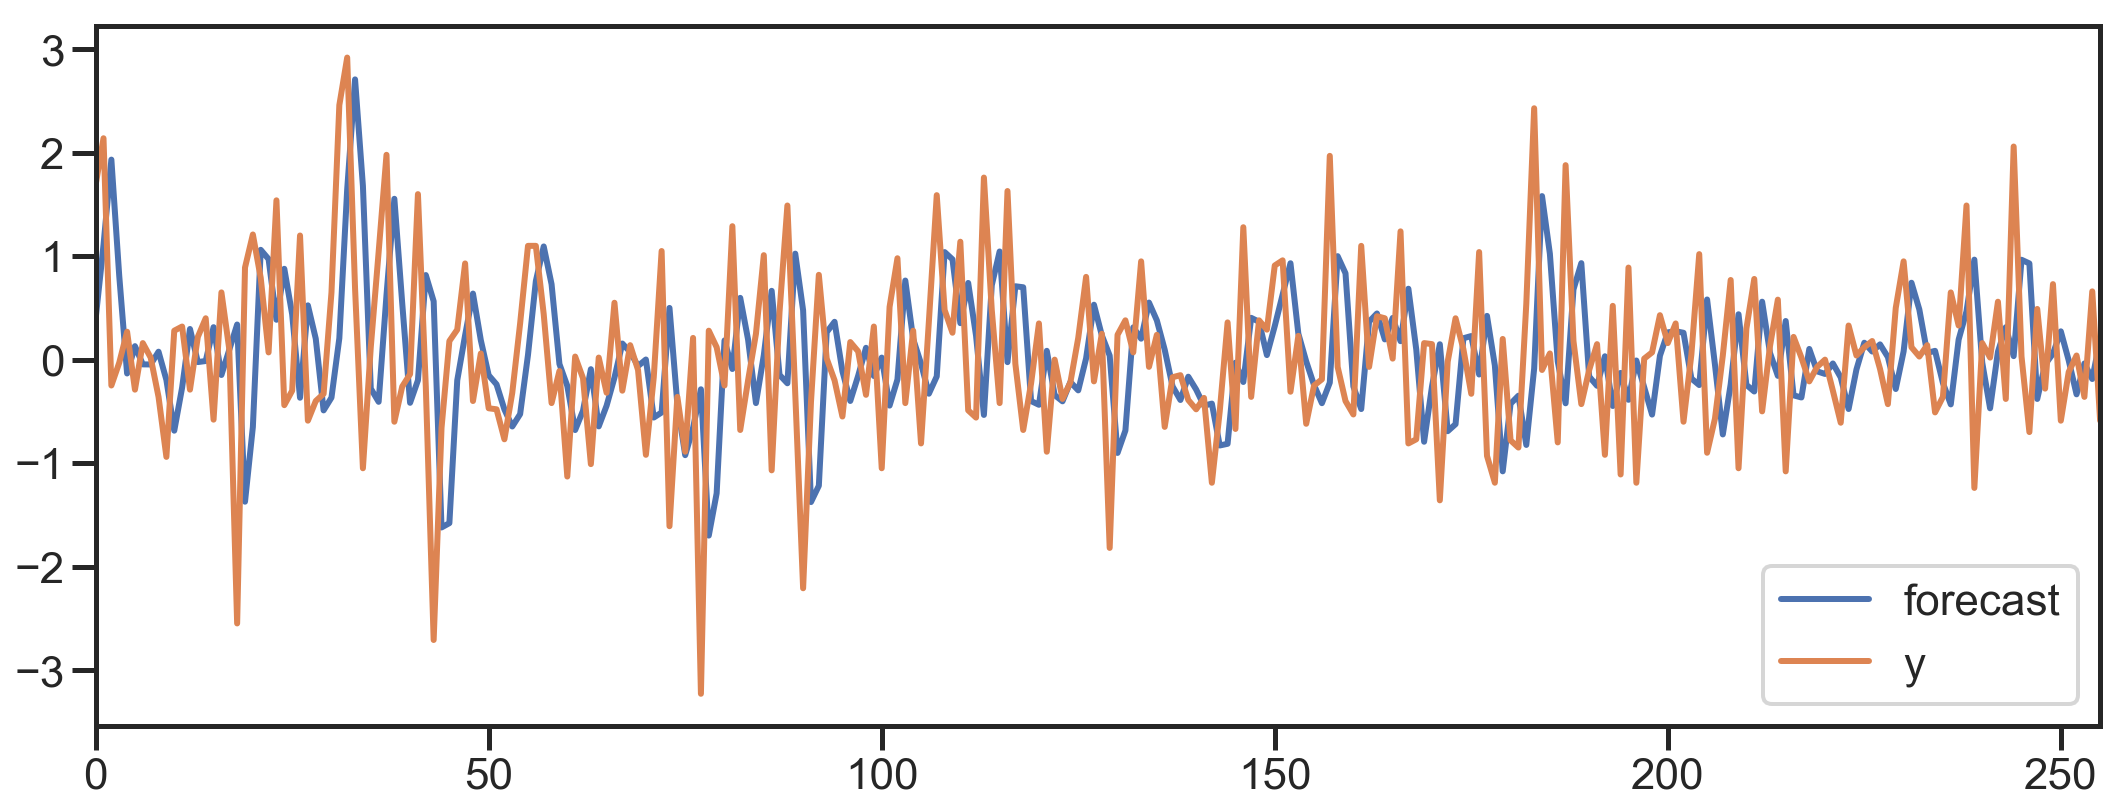

In [181]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(kdxf["close"].diff().iloc[1:].values, order=(1,1,0))
result = model.fit()
print(result.summary())
# result.plot_predict(start=700, end=1000)
result.plot_predict()
plt.show()

### Process Comments Data

In [33]:
path ='/Users/cheriehe/Desktop/Thesis/data/WeiboSuperSpider/topic/'
dates=['20190101-20190103', '20190104-20190106','20190107-20190109','20190110-20190110',
       '20190111-20190111','20190112-20190113','20190114-20190115','20190116-20190117',
       '20190118-20190119','20190120-20190121','20190122-20190123','20190123-20190124',
       '20190125-20190126','20190127-20190129','20190130-20190131','20190201-20190203',
      '20190204-20190207','20190208-20190211','20190212-20190214','20190215-20190217','20190218-20190224',
      '20190226-20190226','20190227-20190227','20190228-20190228','20190303-20190305','20190303-20190305',
      '20190306-20190307','20190308-20190314','20190315-20190316','20190317-20190318','20190319-20190320',
      '20190321-20190322','20190323-20190324','20190325-20190326','20190327-20190328','20190329-20190330',
      '20190331-20190401','20190402-20190404','20190405-20190408','20190409-20190411','20190412-20190414',
      '20190415-20190417','20190418-20190420','20190421-20190423','20190424-20190426','20190427-20190430',
      '20190501-20190505','20190506-20190508','20190509-20190511','20190512-20190514','20190515-20190517',
      '20190518-20190520','20190521-20190521','20190522-20190522','20190523-20190523','20190524-20190525',
      '20190526-20190527','20190528-20190528', '20190529-20190531','20190601-20190604','20190605-20190607',
      '20190608-20190610','20190611-20190613','20190614-20190616','20190616-20190618','20190619-20190619',
      '20190620-20190621','20190622-20190625','20190626-20190628','20190629-20190630','20190701-20190703',
      '20190704-20190706','20190707-20190709','20190710-20190712','20190713-20190717','20190718-20190720',
      '20190721-20190725','20190726-20190731','20190801-20190803','20190807-20190809','20190810-20190812',
      '20190813-20190817','20190818-20190820','20190821-20190823','20190824-20190827','20190828-20190831',
      '20190901-20190903','20190904-20190906','20190907-20190912','20190913-20190918','20190917-20190919',
      '20190919-20190923','20190924-20190928','20190929-20190930','20191001-20191007','20191008-20191008',
      '20191009-20191009', '20191010-20191010','20191011-20191013','20191014-20191016','20191017-20191019',
      '20191020-20191022','20191023-20191024','20191025-20191026','20191027-20191027','20191028-20191031',
      '20191101-20191103','20191104-20191105','20191106-20191108','20191109-20191111','20191112-20191114',
      '20191115-20191119','20191120-20191122','20191123-20191126','20191127-20191130','20191201-20191205',
       '20191205-20191210','20191206-20191210','20191211-20191215','20191216-20191218','20191219-20191221',
       '20191222-20191224','20191225-20191227','20191228-20191231','20200101-20200103','20200104-20200105',
      '20200105-20200106','20200107-20200107','20200108-20200109','20200110-20200121']
comms_total = pd.DataFrame()
for date in dates:
#     print(path+'科大讯飞'+date+'.csv')
    weibo_comms = pd.read_csv(f'{path}科大讯飞{date}.csv')
#     comms_total.append(weibo_comms)
    comms_total = comms_total.append([weibo_comms],ignore_index=True)

In [34]:
del comms_total['Unnamed: 10']
del comms_total['Unnamed: 11']

In [35]:
comms_total.head(3)

,原始图片url,发布位置,发布工具,发布时间,发布者,微博id,微博正文,是否为原创微博,点赞数,被转发微博原始图片url,评论数,转发数
0,无,无,iPhone客户端,2019-01-02 11:30,江淮乘用车,Ha3JVedku,江淮乘用车:#为梦想T速#一辆Dream car 需要什么？更大的空间？更强的动力？更安全的...,True,10510,无,695,5492
1,无,无,微博 weibo.com,2019-01-03 23:39,janw-ong时代,HahWe7BgP,janw-ong时代:#财经# #财经达人说#8月31日，科大讯飞(002230)在提到近期...,True,0,无,0,0
2,无,无,HUAWEI nova 2 Plus,2019-01-03 23:21,a退步原来是向前,HahP92pNt,a退步原来是向前:2019-01-03保险银行如期反弹，券商大飞机领涨航天通信竞价8％直接带...,True,0,无,0,0


In [36]:
comms_total.count()

原始图片url         24742
发布位置            24742
发布工具            24741
发布时间            24742
发布者             24742
微博id            24742
微博正文            24742
是否为原创微博         23680
点赞数             24742
被转发微博原始图片url    23680
评论数             24742
转发数             24742
dtype: int64

In [110]:
comms_total.drop_duplicates(keep='last', inplace=True)

In [38]:
comms_total.count()

原始图片url         21015
发布位置            21015
发布工具            21014
发布时间            21015
发布者             21015
微博id            21015
微博正文            21015
是否为原创微博         20077
点赞数             21015
被转发微博原始图片url    20077
评论数             21015
转发数             21015
dtype: int64

In [39]:
comms_total.tail(2)

,原始图片url,发布位置,发布工具,发布时间,发布者,微博id,微博正文,是否为原创微博,点赞数,被转发微博原始图片url,评论数,转发数
24740,无,无,iPhone客户端,2020-01-13 22:13,飞鹤凌云,IplbvtB1L,转发理由://@绵州一哥:我看好科大讯飞。 \n原始用户: 中欧苹果\n转发内容: 锂电池...,False,0,无,0,0
24741,无,无,HUAWEI P20 Pro,2020-01-13 22:11,练彩人生,Iplaw1bUs,转发理由:转发微博 \n原始用户: 梦想家林奇\n转发内容: #秒拍视频#我分享了 老板联...,False,0,无,0,0


In [40]:
# df.drop(df.index[2])
comms_total=comms_total.drop(comms_total[comms_total['发布工具']=="学习强国客户端"].index.tolist())

In [41]:
comms_total=comms_total.drop(comms_total[comms_total['发布工具']=="什么值得买app"].index.tolist())

In [42]:
comms_total=comms_total.drop(comms_total[comms_total['发布工具']=="买个便宜货"].index.tolist())

In [43]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='股市I黑马云哥'].index.tolist())

In [44]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='股藏干货I'].index.tolist())

In [45]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='用户6890661058'].index.tolist())

In [46]:
comms_total=comms_total.drop(comms_total[comms_total['微博正文']=='转发微博已被删除'].index.tolist())

In [47]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='t金运扣扣'].index.tolist())

In [48]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='命与池鱼'].index.tolist())

In [49]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='本地胖哥的微博'].index.tolist())

In [50]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='戴眼镜的小浣熊'].index.tolist())

In [51]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='北京-传媒服务中心'].index.tolist())

In [52]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='阿彪分析'].index.tolist())

In [53]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='大可爱的专属饲养员'].index.tolist())

In [54]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='酷盖DV'].index.tolist())

In [55]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='向日葵de信念丶'].index.tolist())

In [56]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='杨超分析'].index.tolist())

In [57]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='嘉龙分析'].index.tolist())

In [58]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='狼哥有话说'].index.tolist())

In [59]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='大别针针针'].index.tolist())

In [60]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='壹支小仙女'].index.tolist())

In [61]:
comms_total=comms_total.drop(comms_total[comms_total['发布者']=='飞杨看盘'].index.tolist())

In [62]:
comms_total.count()

原始图片url         19804
发布位置            19804
发布工具            19803
发布时间            19804
发布者             19804
微博id            19804
微博正文            19804
是否为原创微博         18879
点赞数             19804
被转发微博原始图片url    18879
评论数             19804
转发数             19804
dtype: int64

In [63]:
# comms_total=comms_total.drop(comms_total[comms_total['发布者']=='用户7051835203'].index.tolist())

In [64]:
# comms_total=comms_total.drop(comms_total[comms_total['发布者']=='用户7051835203'].index.tolist())

In [65]:
comms_total['微博正文'].drop_duplicates(keep='last', inplace=True)

In [66]:
np.size(comms_total['微博正文'].unique())

17947

In [67]:
comms_total.head()

,原始图片url,发布位置,发布工具,发布时间,发布者,微博id,微博正文,是否为原创微博,点赞数,被转发微博原始图片url,评论数,转发数
1,无,无,微博 weibo.com,2019-01-03 23:39,janw-ong时代,HahWe7BgP,janw-ong时代:#财经# #财经达人说#8月31日，科大讯飞(002230)在提到近期...,True,0,无,0,0
2,无,无,HUAWEI nova 2 Plus,2019-01-03 23:21,a退步原来是向前,HahP92pNt,a退步原来是向前:2019-01-03保险银行如期反弹，券商大飞机领涨航天通信竞价8％直接带...,True,0,无,0,0
3,无,无,UC浏览器,2019-01-03 22:27,这就是名字18,Haht6kPHh,这就是名字18:播客 很简单的东西，比一般别人怎么做的好一点，亮点，类似复利 resourc...,True,0,无,0,0
4,无,无,iPhone客户端,2019-01-03 20:58,AlwaysOline凯,HagTc7lk5,AlwaysOline凯:感受下人工智能，科大讯飞制造 义乌·义亭镇 显示地图 原图,True,0,无,1,0
5,无,无,360安全浏览器,2019-01-03 20:29,逆风猎火,HagHhnQX6,逆风猎火:本日沪指略增量十字星，上影。创业板放量顶5日线压力回撤，上影。日线形态不美。创业板...,True,0,无,0,0


In [68]:
comms_total.isnull().any()

原始图片url         False
发布位置            False
发布工具             True
发布时间            False
发布者             False
微博id            False
微博正文            False
是否为原创微博          True
点赞数             False
被转发微博原始图片url     True
评论数             False
转发数             False
dtype: bool

In [69]:
comms_total=comms_total.drop(comms_total[comms_total['发布时间']=="发布时间"].index.tolist())
comms_total=comms_total.drop(comms_total[comms_total['发布时间']=='是否为原创微博'].index.tolist())
comms_total=comms_total.drop(comms_total[comms_total['发布时间']== 'TRUE'].index.tolist())
comms_total=comms_total.drop(comms_total[comms_total['发布时间']=='FALSE'].index.tolist())

## convert all dates to the same format *%Y-%m-%d*

In [70]:
wb_dates=[]
for dats in comms_total['发布时间'].values.tolist():
    try:
        wb_dates.append(datetime.strftime(datetime.strptime(dats, '%Y-%m-%d %H:%M').date(),'%Y-%m-%d'))
    except:
        wb_dates.append(datetime.strftime(datetime.strptime(dats, '%m/%d/%y %H:%M').date(),'%Y-%m-%d'))

In [71]:
comms_total['发布时间'] = wb_dates
del comms_total['原始图片url']
del comms_total['发布位置']
del comms_total['发布工具']
del comms_total['微博id']
del comms_total['被转发微博原始图片url']
comms_total.head()

,发布时间,发布者,微博正文,是否为原创微博,点赞数,评论数,转发数
1,2019-01-03,janw-ong时代,janw-ong时代:#财经# #财经达人说#8月31日，科大讯飞(002230)在提到近期...,True,0,0,0
2,2019-01-03,a退步原来是向前,a退步原来是向前:2019-01-03保险银行如期反弹，券商大飞机领涨航天通信竞价8％直接带...,True,0,0,0
3,2019-01-03,这就是名字18,这就是名字18:播客 很简单的东西，比一般别人怎么做的好一点，亮点，类似复利 resourc...,True,0,0,0
4,2019-01-03,AlwaysOline凯,AlwaysOline凯:感受下人工智能，科大讯飞制造 义乌·义亭镇 显示地图 原图,True,0,1,0
5,2019-01-03,逆风猎火,逆风猎火:本日沪指略增量十字星，上影。创业板放量顶5日线压力回撤，上影。日线形态不美。创业板...,True,0,0,0


In [72]:
comms_total.count()

发布时间       19731
发布者        19731
微博正文       19731
是否为原创微博    18878
点赞数        19731
评论数        19731
转发数        19731
dtype: int64

In [73]:
comms_total.columns = ['date', 'usr','content', 'if_ori','thumbups', 'comments_num ','numretweets']

In [74]:
# pd.set_option('display.max_rows', None)
usr_efct = comms_total[['usr', 'thumbups']].groupby('usr').count().sort_values('thumbups', ascending=False)

usr_efct['usr']=usr_efct.index
usr_efct.index=range(len(usr_efct))
usr_efct.columns=['usr_thumups', 'usr']
usr_efct.head()

,usr_thumups,usr
0,177,科大讯飞
1,143,科大讯飞sz002230
2,125,小财主五金
3,93,中欧苹果
4,89,淘金者-擒牛


In [75]:
comms_total=comms_total.sort_values('date', ascending=True)
comms_total.index=range(1,len(comms_total)+1)
comms_total=pd.merge(comms_total, usr_efct, how='left', on='usr') 
comms_total.head()

,date,usr,content,if_ori,thumbups,comments_num,numretweets,usr_thumups
0,2019-01-01,股魔独孤求败,股魔独孤求败:元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载...,True,0,0,0,39
1,2019-01-01,语文叫人成功,"转发理由:(1003):""半部论语治天下，三个如果赢A股""之一:牛股的几个特点与几大关系。""...",False,0,1,37,14
2,2019-01-01,书上说我是个社会主义接班人,书上说我是个社会主义接班人:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加...,True,2,2,0,2
3,2019-01-01,书上说我是个社会主义接班人,转发理由:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动...,False,0,0,0,2
4,2019-01-01,帅姐Wendy,帅姐Wendy:我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团...,True,0,0,0,6


In [76]:
comms_total['propn'] = np.size(comms_total['usr'].unique())*comms_total['usr_thumups']/comms_total['usr_thumups'].sum()
comms_total.head(3)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,usr_thumups,propn
0,2019-01-01,股魔独孤求败,股魔独孤求败:元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载...,True,0,0,0,39,2.299559
1,2019-01-01,语文叫人成功,"转发理由:(1003):""半部论语治天下，三个如果赢A股""之一:牛股的几个特点与几大关系。""...",False,0,1,37,14,0.825483
2,2019-01-01,书上说我是个社会主义接班人,书上说我是个社会主义接班人:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加...,True,2,2,0,2,0.117926


In [77]:
comms_total['if_ori'][comms_total['if_ori']==True]=np.ones(len(comms_total[comms_total['if_ori']==True]))
comms_total['if_ori'][comms_total['if_ori']==False]=np.zeros(len(comms_total[comms_total['if_ori']==False]))
comms_total.head(3)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,usr_thumups,propn
0,2019-01-01,股魔独孤求败,股魔独孤求败:元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载...,1,0,0,0,39,2.299559
1,2019-01-01,语文叫人成功,"转发理由:(1003):""半部论语治天下，三个如果赢A股""之一:牛股的几个特点与几大关系。""...",0,0,1,37,14,0.825483
2,2019-01-01,书上说我是个社会主义接班人,书上说我是个社会主义接班人:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加...,1,2,2,0,2,0.117926


In [78]:
del comms_total['usr_thumups']
comms_total.head(3)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn
0,2019-01-01,股魔独孤求败,股魔独孤求败:元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载...,1,0,0,0,2.299559
1,2019-01-01,语文叫人成功,"转发理由:(1003):""半部论语治天下，三个如果赢A股""之一:牛股的几个特点与几大关系。""...",0,0,1,37,0.825483
2,2019-01-01,书上说我是个社会主义接班人,书上说我是个社会主义接班人:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加...,1,2,2,0,0.117926


In [79]:
comms_total['date']=[dates.split(' ')[0] for dates in comms_total['date'].tolist()]
comms_total.sample(5)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn
6340,2019-05-15,心静如水-上海,心静如水-上海:我的白马蓝筹股股池如下：1、金融股：中国平安、招商银行、中信证券2、白酒消费...,1,13,3,9,0.058963
2197,2019-02-14,吴国平财经,吴国平财经:说到东方通信，这是我们之前阶段性挖掘出来的一个龙头品种，我相信之前看过我大文章的...,NaN,3,0,0,0.117926
2736,2019-02-26,小小森林1998,小小森林1998:简单回顾今天盘中比较精彩，大多数高位股与东方大爷荣辱与共，东方通信几次分歧...,1,4,0,0,0.058963
15454,2019-10-29,honstec,honstec:盘面看，奶（伊利）和酒（五粮液）和提到过的食品（中炬高新）稳！科大讯飞最好的...,True,1,0,6,0.707557
8493,2019-06-18,无忌论市,无忌论市:今天平淡且无聊的一天结束了，之前拿过的票也都清了。近期操作不是太顺利，一共操作了三...,True,133,20,0,0.294815


In [80]:
comms_total.count()[0]

19731

In [81]:
# comms_total[comms_total['usr']=='yushui55']
comms_total['content'].iloc[0].split(":")[0]

'股魔独孤求败'

In [82]:
comms_total=comms_total.drop(comms_total[comms_total['content']==0].index.tolist())

In [83]:
# comms_total[comms_total['发布者']=="我是种草囤货酱"]['微博正文'].values[0].split(':')[1]=='天喵618（超级红苞入口）： http'
# get rig of advertisements users
nali = ["我是种草囤货酱",'拍友2641597165', '月明星稀晴','男装潮流穿搭','壹支小仙女','t金运扣扣']
block_names = []
for coms in comms_total['content']:
    for name in nali:
        try:
            if (coms.split(':')[1]==comms_total[comms_total['usr']==name]['content'].values[0].split(":")[1]):
                block_names.append(coms.split(':')[0])
                print(coms.split(':')[0])
        except:
            pass
#             print(coms)

用户6694956734
人生若只如初见y_
谁的幸福rebecca
番茄烧鸡蛋
白洛馨
sure-ing
用户7011490871
迷人的无可救药
用户6450488341
fzhs
木公子1573
用户288nqzibqa
没人能在我的ID里战胜我
布袋小熊521
用户5638395353
小羊羊爱吃肉嘟嘟
薛琴1314520
林寒速
卢鲈鱼LU
七王星53880
miao--涵
Zzz火豆
依缘小丸子
AMYHUANGTIAN
生命是个幻象
陈辉201905
偽媄主义
快乐的土根Ld
小黑805
辣辣的zy
每天都在做早餐
山东大博山
嘻嘻嘻嘻嘿嘿嘿嘿嘿
阳光海浪金沙滩
Tgydwhn
随遇儿6494062771
燕尔霏霏
jamens李
跷跷板0532
勇往直前79163
羽痕iced
melonway
用户6599938489
爱人是猫儿
土豆3921880290
KeEpconFUseD
球球-糊涂
杜山宗
晏自悠0837
梵听竹音0
燕山月2
拍友2641597165
月明星稀晴
依依608
哟喔喔噜
伊秋薇薇
匆匆那年_198412
其实我叫韩xixi
ln静水流深
囤囤3038694161
醒目小白
白菜手册
happy-故事
男装潮流穿搭
男士配搭指南
挖白菜日志
优惠手册
囤货送券菌
白菜优惠攻略
leohanfer2010
全球穿衣搭配
女神搭配日记本
女装时尚搭配笔记
女装穿衣搭配日记
薅羊毛姐姐
微打折
穿丶搭配
男士穿衣学堂
微博时尚排行榜
聪明女人爱穿衣
女生穿衣搭配顾问
女士搭配时尚
白菜师
女装穿衣搭配顾问
囤货种草姐
比特币女超人
穿衣搭配素材
优惠折扣攻略
San0427W
云梦竹nbkaoshi
红磨坊0号
用户6975654736
币圈空投和糖果
行运幸运鱼
优惠秒杀达人
穿衣搭配专区
用户6146367500
女装穿衣打扮
letitgo74652
省钱优惠攻略
Asociety668
s小囡囡
种草囤货女王
全球搭配排行榜
女装配搭攻略
男装时尚搭配顾问
贱贱浅浅
女神搭配穿衣
魅力女人爱穿搭
种草囤货小分队
优惠白菜攻略
化妆很简单good
囤货种草
布谷布谷001
诚意198304
女装品味搭配
王小丹要90斤
女装时尚街拍
爱美的穿衣搭配之路
没有对象就点你
听说名字越稀奇越显得有文化
挖白菜达人
tomato木

In [87]:
len(block_names)

211

In [88]:
for name in block_names:
    comms_total=comms_total.drop(comms_total[comms_total['usr']==name].index.tolist())

comms_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19520 entries, 0 to 19730
Data columns (total 8 columns):
date             19520 non-null object
usr              19520 non-null object
content          19520 non-null object
if_ori           18667 non-null object
thumbups         19520 non-null object
comments_num     19520 non-null object
numretweets      19520 non-null object
propn            19520 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.3+ MB


In [89]:
comms_total.head(3)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn
0,2019-01-01,股魔独孤求败,股魔独孤求败:元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载...,1,0,0,0,2.299559
1,2019-01-01,语文叫人成功,"转发理由:(1003):""半部论语治天下，三个如果赢A股""之一:牛股的几个特点与几大关系。""...",0,0,1,37,0.825483
2,2019-01-01,书上说我是个社会主义接班人,书上说我是个社会主义接班人:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加...,1,2,2,0,0.117926


In [94]:
c2=comms_total[['content', 'propn']]
c2['content'].iloc[2] = c2['content'].iloc[1].split(":")[1]
c2.head()

,content,propn
0,股魔独孤求败:元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载...,2.299559
1,"转发理由:(1003):""半部论语治天下，三个如果赢A股""之一:牛股的几个特点与几大关系。""...",0.825483
2,(1003),0.117926
3,转发理由:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动...,0.117926
4,帅姐Wendy:我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团...,0.353778


In [96]:
c2[c2['content']=='0']

,content,propn


In [97]:
for i in range(len(comms_total['content'])):
    try:
        if len(comms_total['content'].iloc[i].split(":")) <= 2:
            comms_total['content'].iloc[i] = comms_total['content'].iloc[i].split(":")[1]
        elif len(comms_total['content'].iloc[i].split(":")) > 4:
            comms_total['content'].iloc[i] = comms_total['content'].iloc[i].split(":")[1]+comms_total['content'].iloc[i].split(":")[2]+comms_total['content'].iloc[i].split(":")[3]
        else:
            comms_total['content'].iloc[i] = comms_total['content'].iloc[i].split(":")[1]+comms_total['content'].iloc[i].split(":")[2]            
    except:
        print(comms_total['content'].iloc[i].split(':'))

['#小树愿望清单# 想买，科大讯飞翻译机莫比斯智能翻译耳机智能语音耳机多国语言翻译神器 \xa0[组图共4张]\xa0原图\xa0']
['#新浪看点# 618首日战报出炉：科大讯飞品牌销售额排行榜双夺冠618首日战报出炉：科大讯飞品牌销售额排行榜双夺冠 \xa0']
['#小蛮腰撑腰计划# 今天的活动圆满结束。科大讯飞的董事长刘庆峰跟我是同龄人，我已经是中年妇女了，他还是一张娃娃脸。99年采访刚创立的科大讯飞时，谁也不知道20年后的变化。看着一粒种子，破土而出，慢慢发芽，枝叶繁茂，风雨中挺立，阳光下长大。千磨万击还坚劲任尔东西南北风 \xa0']
['#小蛮腰撑腰计划# 刚才有粉丝问没赚钱，当然没赚钱，两成仓位就    一个科大讯飞   为什么要赚钱？   不大亏就行，就像上一次的德新交运，一成，大跌，回到成本区域，也卖，也没赚钱，但是不会对你账户造成大亏损，先保证账户不大亏，如果买了好几个股票，今天全部大幅下跌，低开跳水，你觉得容易赚回? \xa0']
['最近老是听到很多人说速记在两三年内就会被科大讯飞取代，我笑了。其他方面的原因就不说了，虽然说讯飞相比前两年厉害多了，可是哪个单位因为偶尔开一次会议去买一台二十多万的讯飞语音，而且还要另外的人工校对，不能马上出稿。 苡岑岑岑的秒拍视频 \xa0']
['#小蛮腰撑腰计划# #科大讯飞汽车智能网联生态论坛# 开放融合时代，汽车这个曾经改变世界的机器，将会因生态再次被改变！当能听会说、能理解会思考的@科大讯飞 @飞鱼智行 遇见 @奇瑞汽车 有一种专注，是为智能出行而生 \xa0']
['#小蛮腰撑腰计划# #科大讯飞汽车智能网联生态论坛# 开放融合时代，汽车这个曾经改变世界的机器，将会因生态再次被改变！当能听会说、能理解会思考的@科大讯飞 @飞鱼智行 遇见 @奇瑞汽车 有一种专注，是为智能出行而生 \xa0']
['#小蛮腰撑腰计划# 刚才有粉丝问没赚钱，当然没赚钱，两成仓位就    一个科大讯飞   为什么要赚钱？   不大亏就行，就像上一次的德新交运，一成，大跌，回到成本区域，也卖，也没赚钱，但是不会对你账户造成大亏损，先保证账户不大亏，如果买了好几个股票，今天全部大幅下跌，低开跳水，你觉得容易赚回? \xa0']
['科大讯飞已经大跌26%关注 \xa0']
['#小蛮腰撑腰计划# 今天的活动圆满结束。科大

In [98]:
comms_total['content'].iloc[1].split(":")[1]+comms_total['content'].iloc[1].split(":")[2]

IndexError: list index out of range

In [111]:
# comms_total = comms_total.drop([3])
comms_total.head()

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn
0,2019-01-01,股魔独孤求败,元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为...,1,0,0,0,2.299559
1,2019-01-01,语文叫人成功,"(1003)""半部论语治天下，三个如果赢A股""之一牛股的几个特点与几大关系。""几番起落，风云...",0,0,1,37,0.825483
2,2019-01-01,书上说我是个社会主义接班人,2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，...,1,2,2,0,0.117926
4,2019-01-01,帅姐Wendy,我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团队教育微商全体成...,1,0,0,0,0.353778
5,2019-01-01,橙色太阳CM,科大讯飞的叮咚智能语音音箱和天猫精灵同价位的比，音质都很渣；天猫精灵内容上比叮咚多很多；沟通...,1,0,1,0,0.058963


In [112]:
comms_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19237 entries, 0 to 19730
Data columns (total 8 columns):
date             19237 non-null object
usr              19237 non-null object
content          19237 non-null object
if_ori           18387 non-null object
thumbups         19237 non-null object
comments_num     19237 non-null object
numretweets      19237 non-null object
propn            19237 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.3+ MB


In [113]:
# comms_total.to_csv('weibo_comms.csv',index = False)

In [287]:
tweets_num =comms_total[['date', 'content']].groupby('date').count()
# .sort_values('content', ascending=False)
tweets_num.head()

,content
date,
2019-01-01,10
2019-01-02,65
2019-01-03,58
2019-01-04,61
2019-01-05,40


In [288]:
tweets_num.tail(3)

,content
date,
2020-01-19,39
2020-01-20,50
2020-01-21,52


In [289]:
del comms_total['usr']

<h2 style='color:coral'> Guba Comments Data Processing</h2>

In [10]:
def read_news_20(num):
    knews=pd.DataFrame()
    numls = 10*np.arange(num)[10:,]
    for num in numls:
        f_name = f'kdxf_news({num}, {num+10}).csv'
        news = pd.read_csv(f_name)
        knews = knews.append([news],ignore_index=True)
    return knews

In [11]:
def read_news(num):
    knews=pd.DataFrame()
    numls = 5*np.arange(num)[28:,]+np.ones(num-28, dtype=int)
    for num in numls:
        f_name = f'kdxf_news({num}, {num+4}).csv'
        news = pd.read_csv(f_name)
        knews = knews.append([news],ignore_index=True)
    return knews

In [12]:
k20=read_news_20(14)
k20.head()

,title,content,date
0,一大早让我空喜一场。刚开始以为是业绩预报公告，很高兴，心想这下子终于兑现了！再往,一大早让我空喜一场。刚开始以为是业绩预报公告，很高兴，心想这下子终于兑现了！再往下看，原来是...,2020-01-21
1,中标都没用,中标都没用,2020-01-21
2,科大讯飞的主力病了，病的还不轻！,科大讯飞的主力病了，病的还不轻！,2020-01-21
3,垃圾股,垃圾股,2020-01-21
4,36.40最后的加仓机会,36.40最后的加仓机会,2020-01-21


In [13]:
k20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 3 columns):
title      3138 non-null object
content    3066 non-null object
date       3138 non-null object
dtypes: object(3)
memory usage: 73.6+ KB


In [14]:
k20.drop_duplicates(keep='last', inplace=True)
k20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3116 entries, 0 to 3137
Data columns (total 3 columns):
title      3116 non-null object
content    3045 non-null object
date       3116 non-null object
dtypes: object(3)
memory usage: 97.4+ KB


In [15]:
knews = read_news(380)
knews.head()

/Users/cheriehe/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,comments_num,content,date,title
0,0.0,风口来了，“猪”也能飞上天。八哥买股讲究天时地利人和，“天时”即为大势，“地利”为股价的技术...,2019-12-28,风口来了，如何提前布局热点板块？
1,22.0,大家好，我是格菲大师兄Charlie，专注于上市公司和行业的深度研究，我还有六位师兄妹，他们...,2019-12-28,承包一年笑点的高科技股——科大讯飞
2,2.0,俺听说带着绿帽子滴发清漆滴干四托，只能自撸，自撸滴咧,2019-12-28,俺听说带着绿帽子滴发清漆滴干四托，只能自撸，自撸滴咧
3,0.0,要起飞了，火箭发射成功！,2019-12-28,要起飞了，火箭发射成功！
4,4.0,俺有件事始终不明白，俺天天撸干四托，它为何却咬阿凡达呢？,2019-12-28,俺有件事始终不明白，俺天天撸干四托，它为何却咬阿凡达呢？


In [16]:
knews.count()

comments_num     93877
content         131552
date            135139
title           135137
dtype: int64

In [17]:
# comms_total=comms_total.drop(comms_total[comms_total['发布工具']=="学习强国客户端"].index.tolist())
knews = knews.drop(knews[knews['content'].isnull()==True].index.tolist())

In [18]:
knews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131552 entries, 0 to 135138
Data columns (total 4 columns):
comments_num    91321 non-null float64
content         131552 non-null object
date            131552 non-null object
title           131550 non-null object
dtypes: float64(1), object(3)
memory usage: 5.0+ MB


In [19]:
knews['content'].isnull().any()

False

In [20]:
knews[knews['date']=='2019-01-01']

,comments_num,content,date,title
30421,NaN,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。,2019-01-01,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。
33364,NaN,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我们走出如此大...,2019-01-01,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我
34190,NaN,新年吃灰狗。,2019-01-01,新年吃灰狗。
34191,NaN,新年吃灰狗。,2019-01-01,新年吃灰狗。
35418,NaN,看看笑话啦，世界第六聪明公司4美元不到价格，笑话看看啦。看看笑话啦，世界第六聪明公司4美元不...,2019-01-01,看看笑话啦，世界第六聪明公司4美元不到价格，笑话看看啦。[大笑][大笑][大笑]
35467,NaN,科大讯飞 到底牛不牛？我想让各位用科大讯飞的技术来识别一下手镯上的文字。下图是我在多年前老家...,2019-01-01,科大讯飞 到底牛不牛？我想让各位用科大讯飞的技术来识别一下手镯上的文字。 下图是
35469,NaN,看空科大讯飞的，当时代抛弃你的时候，都不会和你说声再见。 看空科大讯飞的，当时代抛弃你的时...,2019-01-01,[大笑][大笑][大笑][大笑][大笑]看空科大讯飞的，当时代抛弃你的时候，都不
35471,NaN,2018年寒流在年底发威，2019年第一天阳光明媚气温己慢慢回暖！严寒过去，春天不会遥远。市...,2019-01-01,2018年寒流在年底发威，2019年第一天阳光明媚气温己慢慢回暖！严寒过去，春天
35482,NaN,新年会遇到的最大问题：中国式的妒忌，美国式的打压，使得无法在全球产品中有效落地，导致业绩长时...,2019-01-01,新年会遇到的最大问题：中国式的妒忌，美国式的打压，使得无法在全球产品中有效落地，
35495,NaN,飞不起来,2019-01-01,飞不起来


### get comments' contents from 2019-01-01 to 2020-01-21

### get rid of data in other dates

In [21]:
knews[['date', 'comments_num']].groupby('date').count().sort_values(by=['date'],ascending=True).head()


,comments_num
date,
2011-08-21,1
2011-12-06,1
2012-09-06,1
2012-12-27,1
2013-05-29,1



### create index of dates

In [22]:
dr1 = pd.date_range(start='1/1/19', end='01/21/20').date
# type(dr1)
news_dat = [dr.strftime("%Y-%m-%d") for dr in dr1]
np.size(news_dat)

386

In [23]:
df_1=pd.concat([k20, knews], ignore_index=True)
df = pd.DataFrame()
# df.index = knews['date']
for dt in news_dat:
    df = df.append([df_1[df_1['date']==dt]],ignore_index=True)

df.head(3)

/Users/cheriehe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,comments_num,content,date,title
0,NaN,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。,2019-01-01,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。
1,NaN,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我们走出如此大...,2019-01-01,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我
2,NaN,新年吃灰狗。,2019-01-01,新年吃灰狗。


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37277 entries, 0 to 37276
Data columns (total 4 columns):
comments_num    382 non-null float64
content         37206 non-null object
date            37277 non-null object
title           37275 non-null object
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [25]:
df.drop_duplicates(keep='last', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36558 entries, 0 to 37276
Data columns (total 4 columns):
comments_num    359 non-null float64
content         36487 non-null object
date            36558 non-null object
title           36556 non-null object
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [26]:
df.sort_values(by=['date'],ascending=True)
df.tail(3)

,comments_num,content,date,title
37274,NaN,只要做评价的都是小散户，还有不懂股票,2020-01-21,只要做评价的都是小散户，还有不懂股票
37275,NaN,不久前，延边大学发布公告称，拟清退136名攻读硕士和博士的学生，原因是这些学生没有在学校规定...,2020-01-21,还想混日子？清华等多所高校清退1300多名研究生
37276,NaN,作者：卓利伟 高毅资产首席研究官1、时间是每个人唯一稀缺的资产做研究最为重要的是时间管理，我...,2020-01-21,一份顶尖私募的内部培训笔记：时间是每个人唯一稀缺的资产


In [27]:
# kdxf= pd.merge(kdxf,df[['date', 'content']].groupby(['date']).count()['content'],left_index=True,right_index=True)
# kdxf['attention'] = kdxf['content']
# del kdxf['content_y']
# kdxf.head(3)

In [28]:
df.head(4)

,comments_num,content,date,title
0,NaN,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。,2019-01-01,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。
1,NaN,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我们走出如此大...,2019-01-01,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我
3,NaN,新年吃灰狗。,2019-01-01,新年吃灰狗。
4,NaN,看看笑话啦，世界第六聪明公司4美元不到价格，笑话看看啦。看看笑话啦，世界第六聪明公司4美元不...,2019-01-01,看看笑话啦，世界第六聪明公司4美元不到价格，笑话看看啦。[大笑][大笑][大笑]


In [29]:
# df[df['comments_num'].isnull()==True]['comments_num'].index.tolist()
# = np.zeros(34017, dtype=int)
df= df.fillna(0)
df.tail(3)

,comments_num,content,date,title
37274,0.0,只要做评价的都是小散户，还有不懂股票,2020-01-21,只要做评价的都是小散户，还有不懂股票
37275,0.0,不久前，延边大学发布公告称，拟清退136名攻读硕士和博士的学生，原因是这些学生没有在学校规定...,2020-01-21,还想混日子？清华等多所高校清退1300多名研究生
37276,0.0,作者：卓利伟 高毅资产首席研究官1、时间是每个人唯一稀缺的资产做研究最为重要的是时间管理，我...,2020-01-21,一份顶尖私募的内部培训笔记：时间是每个人唯一稀缺的资产


In [30]:
del df['title']
df.head(4)

,comments_num,content,date
0,0.0,这里的黎明静俏俏。爆发随时出发。看空就卖。看好就买。买卖自由。,2019-01-01
1,0.0,看遍各种年末回顾，眼花缭乱，貌似逻辑都成立。但我想说，在外围新高不断的情况下，我们走出如此大...,2019-01-01
3,0.0,新年吃灰狗。,2019-01-01
4,0.0,看看笑话啦，世界第六聪明公司4美元不到价格，笑话看看啦。看看笑话啦，世界第六聪明公司4美元不...,2019-01-01


In [31]:
df[['date','comments_num',]].groupby('date').count().head()

,comments_num
date,
2019-01-01,9
2019-01-02,40
2019-01-03,49
2019-01-04,82
2019-01-05,13


In [34]:
comms_total = pd.read_csv('weibo_comms.csv')
comms_total.head(3)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn
0,2019-01-01,股魔独孤求败,元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为...,1.0,0,0,0,2.299559
1,2019-01-01,语文叫人成功,"(1003)""半部论语治天下，三个如果赢A股""之一牛股的几个特点与几大关系。""几番起落，风云...",0.0,0,1,37,0.825483
2,2019-01-01,书上说我是个社会主义接班人,2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，...,1.0,2,2,0,0.117926


In [35]:
comms = pd.concat([comms_total,df],axis=0,join='outer',join_axes=[comms_total.columns],ignore_index=False)
comms.head(3)

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn
0,2019-01-01,股魔独孤求败,元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为...,1.0,0.0,0.0,0.0,2.299559
1,2019-01-01,语文叫人成功,"(1003)""半部论语治天下，三个如果赢A股""之一牛股的几个特点与几大关系。""几番起落，风云...",0.0,0.0,1.0,37.0,0.825483
2,2019-01-01,书上说我是个社会主义接班人,2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，...,1.0,2.0,2.0,0.0,0.117926


In [42]:
comms.drop_duplicates(keep='last', inplace=True)

In [43]:
comms=comms.drop(comms[comms['content']==0].index.tolist())

In [44]:
comms[comms['content']==0]

,date,usr,content,if_ori,thumbups,comments_num,numretweets,propn


In [45]:
comms.count()

date             55490
usr              19237
content          55490
if_ori           18387
thumbups         19237
comments_num     19237
numretweets      19237
propn            19237
dtype: int64

In [46]:
comms['content'].count()

55490

In [47]:
comms['cleaned_contents'] = None
cleaned_contents=[]

In [48]:
for com in comms['content']:
    try:
        if len(com)>=100:
            com=com[:101]
        elif len(com)<=50:
            com = com[:36]
        cleaned_contents.append(com)
    except:
        print(f"fail to read : {com}")
    
#     print(type(com))

In [49]:
len(cleaned_contents)

55490

In [50]:
# cleaned_contents.append(comms['content'].loc[0].values[0][:36])
comms['cleaned_contents'] = cleaned_contents
del comms['content']

In [51]:
comms['cleaned_contents'].head(20)

0     元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为...
1     (1003)"半部论语治天下，三个如果赢A股"之一牛股的几个特点与几大关系。"几番起落，风云...
2     2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，...
3     我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团队教育微商全体成...
4     科大讯飞的叮咚智能语音音箱和天猫精灵同价位的比，音质都很渣；天猫精灵内容上比叮咚多很多；沟通...
5     转发微博//@斯威汽车#SWM斯威X7互联版#科大讯飞智能语音控制系统，为用户带来便捷的智能...
6     #口袋神器# 华为，大疆，科大讯飞……欣喜看到这些自主品牌完胜竞品，去年十月美国用大疆的Os...
7                索菲亚和科大讯飞的AI已经能理解了  \n原始用户 爱可可-爱生活\n转发内
8     #字述一年# 我是@科大讯飞 ，2018年就是一个字：智。【VIVI积极扩散，期待好运哦】！...
9     1、         今日超大单：上证（000001）-9.35亿、深成（399001）-1...
10                002230科大讯飞，这只今年要飞  \n原始用户 证券时报网\n转发内容
11                         止盈$科大讯飞 sz002230$ 。落袋为安  原图 
12               002230科大讯飞，明年语言智能会爆发的  \n原始用户 证券时报网\n转
13    $沪电股份 sz002463$$科大讯飞 sz002230$ http//t.cn/EbD8...
14    【1月2日市场主力资金流向】#军工# 主力净流入行业板块前五：包装材料、航天军工、化纤、木业...
15               002230科大讯飞啊，搏一把吧！嘿嘿😁  \n原始用户 证券时报网\n转发
16    发布了头条文章：《2019年A股开门黑后，是风险还是机会？》 2019年A股开门黑后，是风险...
17    #世界的中国力量# 科技改变生活，有A.I.，更美好。@科大讯飞 与 @零跑汽车 一

In [52]:
comms.head()

,date,usr,if_ori,thumbups,comments_num,numretweets,propn,cleaned_contents
0,2019-01-01,股魔独孤求败,1.0,0.0,0.0,0.0,2.299559,元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为...
1,2019-01-01,语文叫人成功,0.0,0.0,1.0,37.0,0.825483,"(1003)""半部论语治天下，三个如果赢A股""之一牛股的几个特点与几大关系。""几番起落，风云..."
2,2019-01-01,书上说我是个社会主义接班人,1.0,2.0,2.0,0.0,0.117926,2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，...
3,2019-01-01,帅姐Wendy,1.0,0.0,0.0,0.0,0.353778,我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团队教育微商全体成...
4,2019-01-01,橙色太阳CM,1.0,0.0,1.0,0.0,0.058963,科大讯飞的叮咚智能语音音箱和天猫精灵同价位的比，音质都很渣；天猫精灵内容上比叮咚多很多；沟通...


In [57]:
comms.to_csv('kdxfnews.csv',index=False)

In [75]:
kdxf= pd.merge(kdxf,comms[['date','cleaned_contents']].groupby('date').count(),left_index = True, right_index = True)
kdxf.head()

,code,open,high,low,close,preclose,volume,amount,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,date,cleaned_contents
date,,,,,,,,,,,,,,,,,,
2019-01-02,sz.002230,24.63,25.35,24.61,25.04,24.64,32894190,8.256631e+08,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,2019-01-02,105
2019-01-03,sz.002230,24.98,25.85,24.88,25.44,25.04,41748458,1.061824e+09,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,2019-01-03,107
2019-01-04,sz.002230,25.16,27.46,25.01,27.13,25.44,68481699,1.806189e+09,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,2019-01-04,142
2019-01-07,sz.002230,27.49,29.58,27.20,29.27,27.13,81114177,2.326280e+09,4.451259,7.887952,126.243501,7.986690,8.342985,-78.393748,2533.088,0.850157,2019-01-07,268
2019-01-08,sz.002230,29.39,29.88,28.60,29.02,29.27,57752434,1.679223e+09,3.169249,-0.854117,125.165234,7.918474,8.271726,-77.724173,2526.462,0.674497,2019-01-08,179


In [76]:
 # comms['attention'] = None
kdxf['attention'] = kdxf['cleaned_contents']
del kdxf['cleaned_contents']
kdxf.head(3)

,code,open,high,low,close,preclose,volume,amount,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,date,attention
date,,,,,,,,,,,,,,,,,,
2019-01-02,sz.002230,24.63,25.35,24.61,25.04,24.64,32894190,8.256631e+08,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,2019-01-02,105
2019-01-03,sz.002230,24.98,25.85,24.88,25.44,25.04,41748458,1.061824e+09,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,2019-01-03,107
2019-01-04,sz.002230,25.16,27.46,25.01,27.13,25.44,68481699,1.806189e+09,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,2019-01-04,142


### Sentiment Analysis

In [327]:
comms['sentiment'] = None

In [ ]:
import senti as ST

for i in 10*np.arange(int(len(comms['cleaned_contents'])/10 + 1))[:,]:
    try:
    #     sentiment = ST.get_label(comms['content'].iloc[i:i+10,])
    #     senti.extend(sentiment)
        comms['sentiment'].iloc[i:i+10,] = ST.get_label(comms['cleaned_contents'].iloc[i:i+10,])
        print("\n-----page",int(i/10),"---------\n")
        #     print(senti)
    except:
        print(f"\n-- page {i}-{i+10} fail to read\n")

元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为友，其操盘手法犀利，快、准、狠、稳，我将以每天战绩令世人惊叹！正元智慧，恒立实业，贵州茅台，上证指数，上证50 
 1 
--------------------
转发理由:(1003):"半部论语治天下，三个如果赢A股"之一:牛股的几个特点与几大关系。"几番起落，风云振作，赶他个天时地利与人和"。资本市场的兴旺，必将造就更多华为·腾讯·阿里巴巴，小米·联想·大族 
 1 
--------------------
书上说我是个社会主义接班人:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，感谢科大讯飞提供文本支持，感谢腾讯网提供技术支持，感谢小米集团提供硬件支持！  原 
 1 
--------------------
转发理由:2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，感谢科大讯飞提供文本支持，感谢新浪网提供技术支持，感谢小米集团提供硬件支持！   
原始用户: 大连 
 1 
--------------------
帅姐Wendy:我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团队教育微商全体成员祝愿大家元旦快乐心想事成……[爱心] http://t.cn/Ebm6mVL  原图  
 1 
--------------------
橙色太阳CM:科大讯飞的叮咚智能语音音箱和天猫精灵同价位的比，音质都很渣；天猫精灵内容上比叮咚多很多；沟通上天猫更丰富一些，叮咚比较生硬；开放性天猫没的说，支持大部分，配合黑豆或者小方传统家电也可以控制 
 1 
--------------------
转发理由:转发微博//@斯威汽车:#SWM斯威X7互联版#科大讯飞智能语音控制系统，为用户带来便捷的智能操控体验。让你“动口不动手”，大大提高行车安全。   
原始用户: 斯威汽车
转发内容: #SWM 
 1 
--------------------
魏来king:#口袋神器# 华为，大疆，科大讯飞……欣喜看到这些自主品牌完胜竞品，去年十月美国用大疆的Osmo手机云台就引来歪果仁目瞪口呆，如今这款口袋神器云台相机更是完胜gopro！ 上海  显示地图 
 1 



-- page 80-90 fail to read

我是逗你玩儿:《长三角新奋进｜“让世界聆听我们的声音” 科大讯飞从合肥飞向全球》图说：安徽合肥科技创新服务中心新民晚报记者、陶磊、摄。http://t.cn/EGZf6aK  原图  
 1 
--------------------

-- page 90-100 fail to read


-- page 100-110 fail to read


-- page 110-120 fail to read


-- page 120-130 fail to read


-- page 130-140 fail to read


-- page 140-150 fail to read


-- page 150-160 fail to read


-- page 160-170 fail to read


-- page 170-180 fail to read


-- page 180-190 fail to read


-- page 190-200 fail to read


-- page 200-210 fail to read


-- page 210-220 fail to read


-- page 220-230 fail to read


-- page 230-240 fail to read


-- page 240-250 fail to read


-- page 250-260 fail to read


-- page 260-270 fail to read


-- page 270-280 fail to read


-- page 280-290 fail to read


-- page 290-300 fail to read


-- page 300-310 fail to read


-- page 310-320 fail to read


-- page 320-330 fail to read


-- page 330-340 fail to read


-- page 340-350 fail to read


-- page 350-360 fail to read

夜风8号:#同花顺##科大讯飞#买

In [ ]:
print(comms['sentiment'].count())
comms.head()

In [ ]:
comms['sentiment'].count()

### Using SVM method to predict

In [487]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
# from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pickle
import datetime
import os
import subprocess
import sys
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [488]:
def loadDataFiles(mkt, news):
    market_df = pd.read_csv(mkt+'.csv')
    news_df = pd.read_csv(news+'.csv')
    print('Finished loading datafiles!')
    return market_df, news_df

def preprocess_data(mkt_df, news_df):
    mkt_df['date'] = pd.to_datetime(mkt_df['date'])
    news_df['date'] = pd.to_datetime(news_df['date'])
    mkt_df['date'] = mkt_df['date'].dt.date
    news_df['date'] = news_df['date'].dt.date
    merged = pd.merge(mkt_df, news_df, how='left', on=['date'], copy=False) 
    merged = merged.fillna(0)
    print('Finished preprocessing data!')
    return merged

def regularize(df):
    for column in df:
        colmin = np.amin(df[column])
        colmax = np.amax(df[column])
        df[column] = (df[column] - colmin) / (colmax - colmin)
    return df

In [489]:
market_df, news_df = loadDataFiles('mkt_data', 'kdxfnews')

Finished loading datafiles!


In [490]:
market_df.head(3)

,close,volume,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,date,attention,upordown
0,25.04,32894190,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,2019-01-02,105,1
1,25.44,41748458,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,2019-01-03,107,1
2,27.13,68481699,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,2019-01-04,142,1


In [491]:
news_df.head()

,date,usr,if_ori,thumbups,comments_num,numretweets,propn,cleaned_contents
0,2019-01-01,股魔独孤求败,1.0,0.0,0.0,0.0,2.299559,元旦回来只求一败，一个月时间盈利50点以上过春节。股魔独孤求败，纵横股市十馀载，以纳米指标为...
1,2019-01-01,语文叫人成功,0.0,0.0,1.0,37.0,0.825483,"(1003)""半部论语治天下，三个如果赢A股""之一牛股的几个特点与几大关系。""几番起落，风云..."
2,2019-01-01,书上说我是个社会主义接班人,1.0,2.0,2.0,0.0,0.117926,2019愿你又瘦又好看有钱还可爱，新的一年好运爆棚愿望通通实现加油!这是一条纯手动发的说话，...
3,2019-01-01,帅姐Wendy,1.0,0.0,0.0,0.0,0.353778,我上传了一个视频 『川爸团队•祝福到』新的一年给您美好祝福科大讯飞川爸冠军团队教育微商全体成...
4,2019-01-01,橙色太阳CM,1.0,0.0,1.0,0.0,0.058963,科大讯飞的叮咚智能语音音箱和天猫精灵同价位的比，音质都很渣；天猫精灵内容上比叮咚多很多；沟通...


In [492]:
new=news_df[['date','thumbups','numretweets','propn']].groupby('date').mean().head()
new['date'] = new.index
new.sample(3)
new.index=range(len(new))
new.sample(5)

,thumbups,numretweets,propn,date
3,1.934426,1.327869,0.532601,2019-01-04
2,2.327586,3.034483,0.833616,2019-01-03
0,0.333333,4.111111,0.432396,2019-01-01
4,0.236842,3.710526,0.917031,2019-01-05
1,164.615385,88.584615,0.761984,2019-01-02


In [493]:
dataset=preprocess_data(market_df, new)
dataset.head(5)

Finished preprocessing data!


,close,volume,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,date,attention,upordown,thumbups,numretweets,propn
0,25.04,32894190,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,2019-01-02,105,1,164.615385,88.584615,0.761984
1,25.44,41748458,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,2019-01-03,107,1,2.327586,3.034483,0.833616
2,27.13,68481699,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,2019-01-04,142,1,1.934426,1.327869,0.532601
3,29.27,81114177,4.451259,7.887952,126.243501,7.986690,8.342985,-78.393748,2533.088,0.850157,2019-01-07,268,1,0.000000,0.000000,0.000000
4,29.02,57752434,3.169249,-0.854117,125.165234,7.918474,8.271726,-77.724173,2526.462,0.674497,2019-01-08,179,-1,0.000000,0.000000,0.000000


In [494]:
date=dataset['date']
date.head(3)

0    2019-01-02
1    2019-01-03
2    2019-01-04
Name: date, dtype: object

In [495]:
del dataset['date']
dataset.head(3)

,close,volume,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,attention,upordown,thumbups,numretweets,propn
0,25.04,32894190,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,105,1,164.615385,88.584615,0.761984
1,25.44,41748458,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,107,1,2.327586,3.034483,0.833616
2,27.13,68481699,3.758034,6.643076,117.013536,7.402764,7.733009,-72.662192,2514.868,-1.085425,142,1,1.934426,1.327869,0.532601


In [496]:
dataset.iloc[:,2:14].head(2)

,turn,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,close_sz300,withoutsz300,attention,upordown,thumbups,numretweets
0,1.805117,1.623383,107.999223,6.832481,7.137286,-67.064552,2465.291,-2.619198,105,1,164.615385,88.584615
1,2.291008,1.597443,109.724451,6.941626,7.251300,-68.135871,2464.362,-2.208776,107,1,2.327586,3.034483


In [497]:
#1 Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from mlxtend.plotting import plot_decision_regions
#2 Importing the dataset
# dataset = pd.read_csv('Position_Salaries.csv')
y = dataset.iloc[:,0:1].values.astype(float)
X = dataset.iloc[:,2:14].values.astype(float)
# #3 Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = sc_X.fit_transform(X)
# y = sc_y.fit_transform(y)

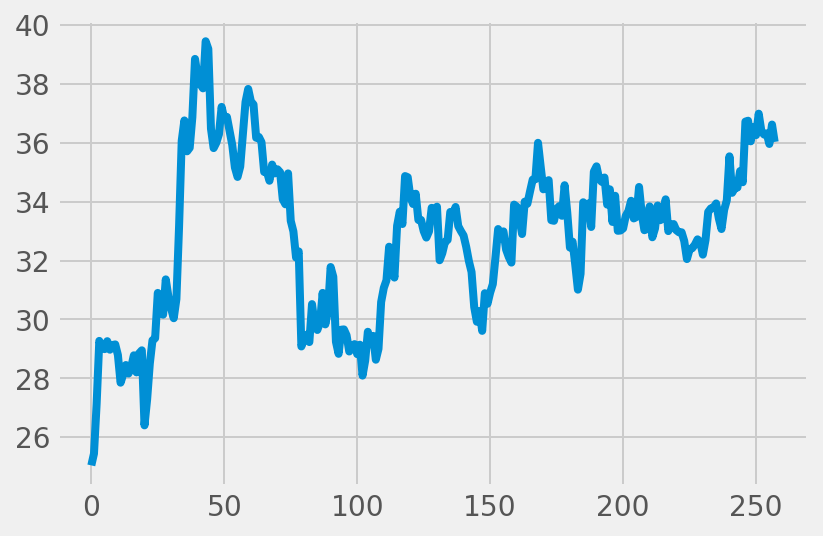

In [498]:
plt.plot(y)

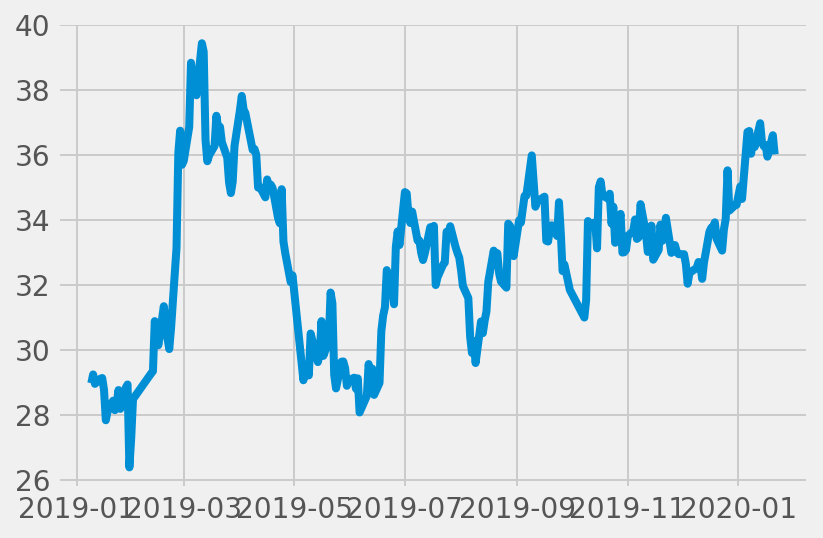

In [499]:
to_y=[]
for i in range(len(y)):
    to_y.extend(y.tolist()[i])
to_y = pd.Series(to_y[5:], index=date[5:]) 
plt.plot(to_y)

In [500]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import StandardScaler
# X = regularize(X)
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

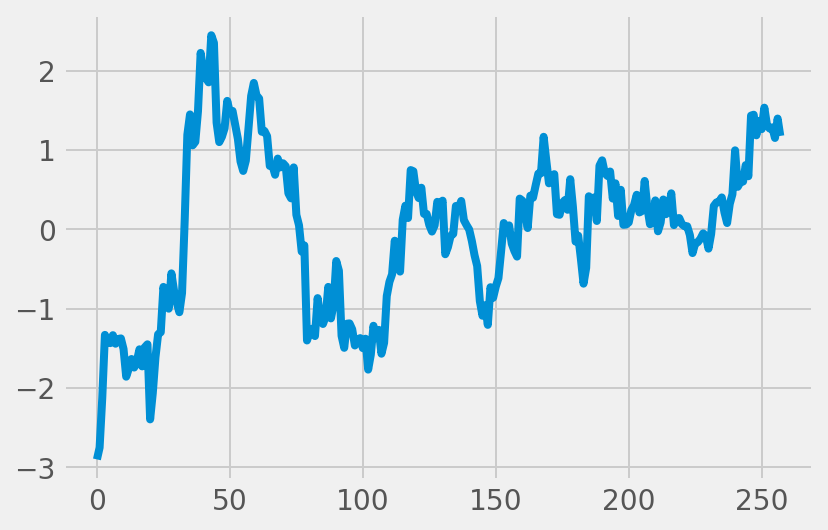

In [501]:
plt.plot(y)

In [502]:
y[0:3]

array([[-2.90014809],
       [-2.75175879],
       [-2.124814  ]])

In [503]:
X[0]

array([-0.26957147,  0.56608868, -1.04347946, -1.16964703, -1.75606224,
        0.17274716, -2.9439099 , -1.59625119, -0.87424471,  0.94713189,
       16.02852071, 16.02005253])

In [504]:
np.size(X)/12

258.0

In [505]:
num = 5
X_1 = []
for i in range(len(y[num:])): 
    x=[]
    for j in range(num):
        x.extend(X[i:i+num].astype(float)[j])
    X_1.append(x)

In [506]:
X_1= np.array(X_1)
X_1[0]

array([-0.26957147,  0.56608868, -1.04347946, -1.16964703, -1.75606224,
        0.17274716, -2.9439099 , -1.59625119, -0.87424471,  0.94713189,
       16.02852071, 16.02005253,  0.12869798,  0.55590899, -0.91048168,
       -1.07067738, -1.58353071,  0.16615611, -2.94981239, -1.346122  ,
       -0.85385923,  0.94713189,  0.16355174,  0.48559375,  1.3311727 ,
        2.53597634, -0.3485663 , -0.65253024, -0.85458519,  0.13830894,
       -2.62891747, -0.6615042 , -0.49711334,  0.94713189,  0.12511712,
        0.1757015 ,  1.89938726,  3.02450539,  0.36297146, -0.12304235,
        0.06846019,  0.10304684, -2.51315488,  0.51812182,  0.78717185,
        0.94713189, -0.06398898, -0.06541705,  0.84856429, -0.40616135,
        0.27984789, -0.18489873, -0.0393724 ,  0.10716625, -2.55525383,
        0.41106716, -0.11998198, -1.05581916, -0.06398898, -0.06541705])

In [507]:
253-len(X_1)*0.2

202.4

In [508]:
np.size(X_1)/12

1265.0

In [509]:
198+55

253

In [511]:
#split train data and test data
from sklearn.model_selection import cross_val_score, train_test_split
X_train=X_1[:203]
X_test=X_1[203:]
y_train=y[5:208]
y_test=y[208:]

In [512]:
len(X_train)

203

In [513]:
len(X_test)

50

In [514]:
np.size(y_test)

50

In [515]:
# #4 Fitting the Support Vector Regression Model to the dataset
# # Create your support vector regressor here
# from sklearn.svm import SVR
# # most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
# model = SVR(C=100,gamma=0.01, kernel='rbf')

# model.fit(X_train, y_train)

In [516]:
X_train[0]

array([-0.26957147,  0.56608868, -1.04347946, -1.16964703, -1.75606224,
        0.17274716, -2.9439099 , -1.59625119, -0.87424471,  0.94713189,
       16.02852071, 16.02005253,  0.12869798,  0.55590899, -0.91048168,
       -1.07067738, -1.58353071,  0.16615611, -2.94981239, -1.346122  ,
       -0.85385923,  0.94713189,  0.16355174,  0.48559375,  1.3311727 ,
        2.53597634, -0.3485663 , -0.65253024, -0.85458519,  0.13830894,
       -2.62891747, -0.6615042 , -0.49711334,  0.94713189,  0.12511712,
        0.1757015 ,  1.89938726,  3.02450539,  0.36297146, -0.12304235,
        0.06846019,  0.10304684, -2.51315488,  0.51812182,  0.78717185,
        0.94713189, -0.06398898, -0.06541705,  0.84856429, -0.40616135,
        0.27984789, -0.18489873, -0.0393724 ,  0.10716625, -2.55525383,
        0.41106716, -0.11998198, -1.05581916, -0.06398898, -0.06541705])

In [517]:
y_test[0]

array([0.06392818])

In [518]:
len(train)

203

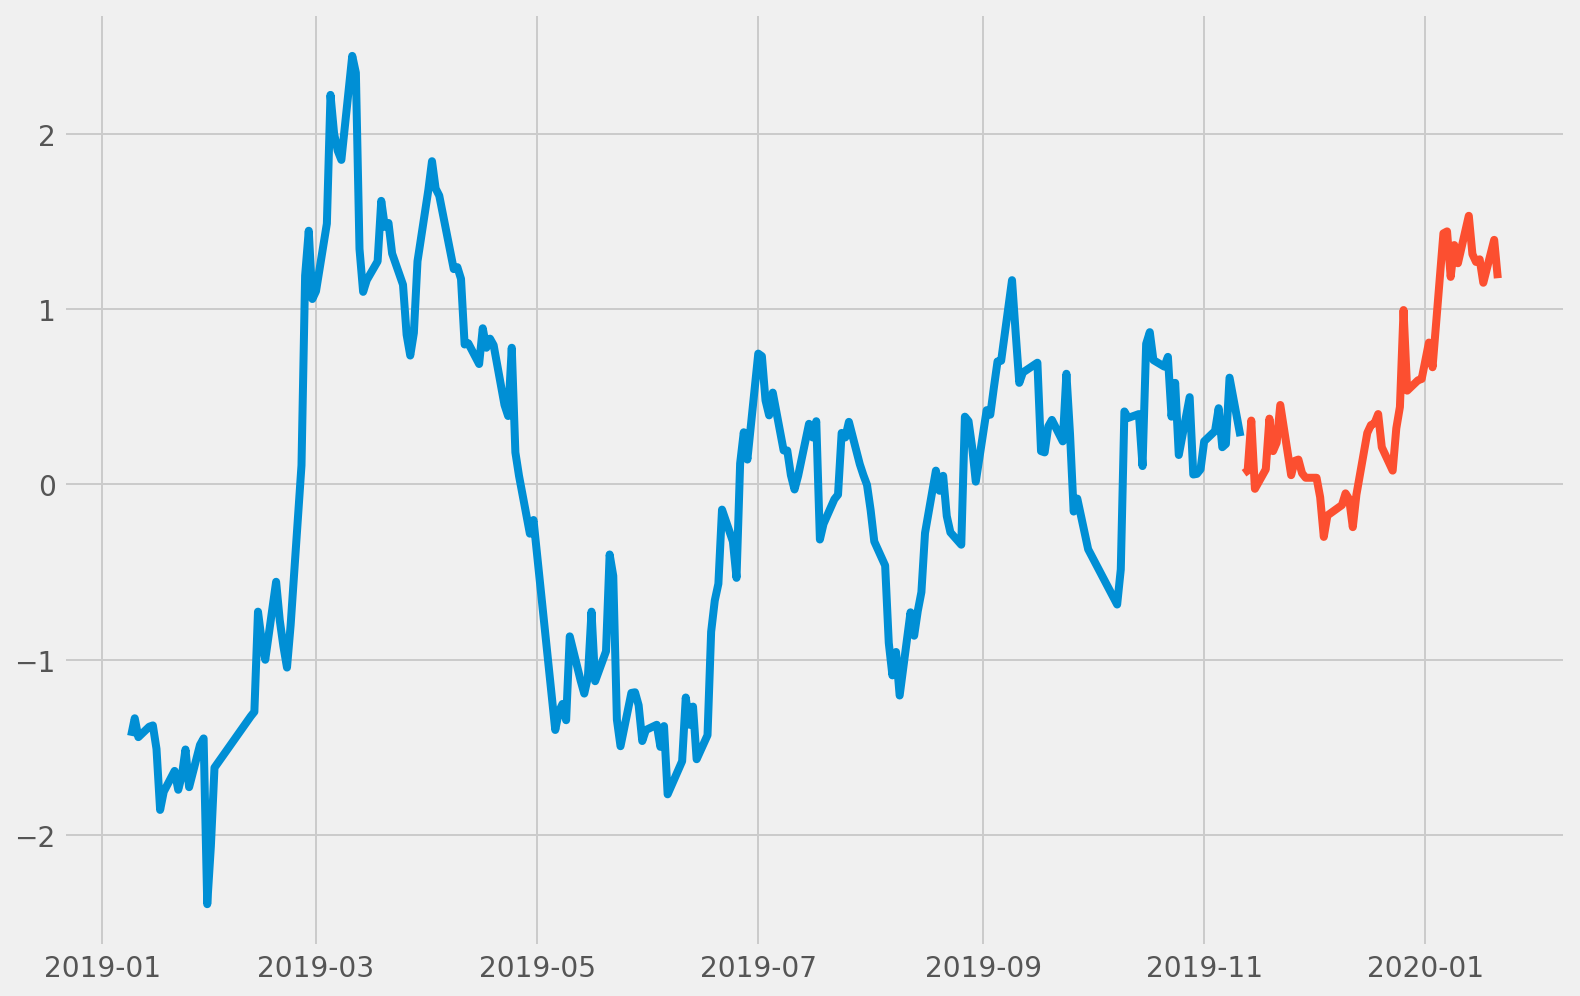

In [519]:
fig = plt.figure(figsize=(12,8))
train=[]
for i in range(len(y_train)):
    train.extend(y_train.tolist()[i])
train = pd.Series(train, index=date[5:208]) 
plt.plot(train)
test=[]
for i in range(len(y_test)):
    test.extend(y_test.tolist()[i])   
test = pd.Series(test,index=date[208:])
# test.index=test.index+202
plt.plot(test)

In [520]:
y_train[0]

array([-1.43480375])

In [521]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear']} 

grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=1, cv=10, iid=True)

grid.fit(X_train, y_train.T.ravel())

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:  6.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 100], 'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [200]:
# model?

In [251]:
grid.best_params_

{'C': 0.5, 'gamma': 1, 'kernel': 'linear'}

In [252]:
grid.best_score_

0.04383178407853807

In [326]:
grid.cv_results_

/Users/cheriehe/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/cheriehe/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/cheriehe/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/cheriehe/anacon

{'mean_fit_time': array([5.20534515e-03, 5.09636402e-03, 3.08489799e-03, 4.85532284e-03,
        4.79443073e-03, 2.90830135e-03, 3.19077969e-03, 3.26139927e-03,
        2.00419426e-03, 2.61752605e-03, 3.16843987e-03, 2.10471153e-03,
        2.22058296e-03, 2.49929428e-03, 2.55584717e-03, 2.79867649e-03,
        2.17974186e-03, 2.21517086e-03, 2.24871635e-03, 2.79774666e-03,
        2.39617825e-03, 3.09309959e-03, 3.46713066e-03, 4.65135574e-03,
        2.86302567e-03, 3.31187248e-03, 4.14874554e-03, 2.57587433e-03,
        3.23507786e-03, 4.32112217e-03, 2.44333744e-03, 3.26182842e-03,
        4.20498848e-03, 2.25481987e-03, 3.35116386e-03, 4.16340828e-03,
        2.15249062e-03, 1.83262825e-03, 4.28285599e-03, 2.42736340e-03,
        1.77025795e-03, 4.32088375e-03, 3.44843864e-03, 3.49547863e-03,
        1.58921242e-02, 3.97672653e-03, 4.17535305e-03, 1.88471079e-02,
        3.63626480e-03, 4.44440842e-03, 1.89129829e-02, 3.19528580e-03,
        4.03549671e-03, 1.51720762e-02, 2.41930

In [253]:
grid.score(X_test, y_test)

0.8120343689624746

In [254]:
grid.score(X_train, y_train)

0.9188688612771729

In [351]:
#5 Predicting a new result
grid.predict(X_test)

array([ 0.3402413 ,  0.03124063,  0.12700214,  0.32262286,  0.03928251,
        0.08661803,  0.43779281,  0.27715421,  0.18488107,  0.54134267,
        0.1439412 ,  0.12691835,  0.25579284,  0.15338278,  0.05081892,
        0.04677196, -0.03387895, -0.22267348, -0.12188529, -0.09285879,
       -0.03863335, -0.00218755,  0.05701505, -0.15024336, -0.05534182,
        0.4214933 ,  0.34207222,  0.38716854,  0.4483728 ,  0.28467833,
        0.15624449,  0.26699412,  0.37031664,  1.03174873,  0.54533372,
        0.52955253,  0.74022224,  0.80183969,  0.77802705,  1.51032194,
        1.35357276,  1.01689681,  1.3489457 ,  1.1249859 ,  1.45749055,
        1.3318086 ,  1.23796704,  1.18878656,  1.141736  ,  1.29377009])

In [45]:
grid?

In [256]:
grid.best_score_ 

0.04383178407853807

In [318]:
y_train_reverse = sc_y.inverse_transform(y_train)
y_train_reverse

array([[28.99],
       [29.26],
       [28.97],
       [29.13],
       [29.15],
       [28.79],
       [27.85],
       [28.13],
       [28.45],
       [28.16],
       [28.38],
       [28.78],
       [28.2 ],
       [28.85],
       [28.95],
       [26.4 ],
       [27.29],
       [28.5 ],
       [29.29],
       [29.36],
       [30.9 ],
       [30.46],
       [30.16],
       [31.36],
       [30.77],
       [30.37],
       [30.04],
       [30.69],
       [33.15],
       [36.07],
       [36.76],
       [35.71],
       [35.83],
       [36.87],
       [38.85],
       [38.25],
       [37.99],
       [37.85],
       [39.45],
       [39.19],
       [36.48],
       [35.82],
       [36.  ],
       [36.29],
       [37.22],
       [36.82],
       [36.88],
       [36.41],
       [35.93],
       [35.16],
       [34.84],
       [35.19],
       [36.29],
       [37.39],
       [37.83],
       [37.41],
       [37.3 ],
       [36.17],
       [36.2 ],
       [36.02],
       [35.01],
       [35.03],
       [

In [362]:
pre_reverse = sc_y.inverse_transform(grid.predict(X_test))
pre_reverse

array([33.77483299, 32.94188704, 33.20002292, 33.72734053, 32.96356483,
       33.09116302, 34.03779404, 33.60477466, 33.35604208, 34.31692429,
       33.24568406, 33.19979707, 33.5471927 , 33.27113491, 32.99466251,
       32.98375348, 32.7663499 , 32.25743308, 32.52911895, 32.60736313,
       32.75353388, 32.85177764, 33.01136489, 32.4526766 , 32.70849433,
       33.99385688, 33.77976846, 33.90133064, 34.06631358, 33.62505677,
       33.27884896, 33.57738702, 33.85590444, 35.63886882, 34.32768263,
       34.28514265, 34.85302649, 35.01912323, 34.95493359, 36.92891659,
       36.50638158, 35.5988338 , 36.49390884, 35.89020008, 36.78650364,
       36.44771384, 36.19475342, 36.0621819 , 35.93535185, 36.34517679])

In [365]:
# to_y[203:]

In [334]:
ytr=[]
for i in range(len(y_train)):
    ytr.extend(y_train.tolist()[i])
    
ytr = pd.Series(ytr)
# ytr.index = range(len(y_train))
# ytr.index=ytr.index+1

In [265]:
# len(ytr)
ytr = pd.Series(ytr)
ytr.count()

253

In [331]:
pre=pre_reverse
pre=pd.Series(pre.tolist(),index=date[208:])
# pre.index=range(202,len(pre)+202)

In [332]:
pre.head(3)

date
2019-11-12    33.774833
2019-11-13    32.941887
2019-11-14    33.200023
dtype: float64

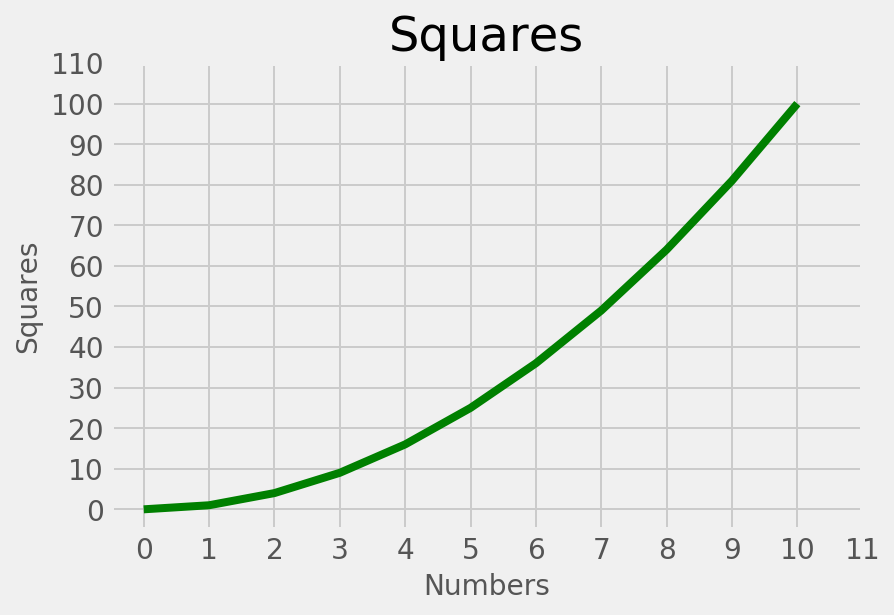

In [394]:
from matplotlib.pyplot import MultipleLocator
#从pyplot导入MultipleLocator类，这个类用于设置刻度间隔
  
x_values=list(range(11))
y_values=[x**2 for x in x_values]
plt.plot(x_values,y_values,c='green')
plt.title('Squares',fontsize=24)
plt.tick_params(axis='both',which='major',labelsize=14)
plt.xlabel('Numbers',fontsize=14)
plt.ylabel('Squares',fontsize=14)
x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlim(-0.5,11)
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.ylim(-5,110)
#把y轴的刻度范围设置为-5到110，同理，-5不会标出来，但是能看到一点空白
plt.show()

In [425]:
news_dat = [dr.strftime("%Y-%m-%d") for dr in date[208:]]
np.size(news_dat)

50

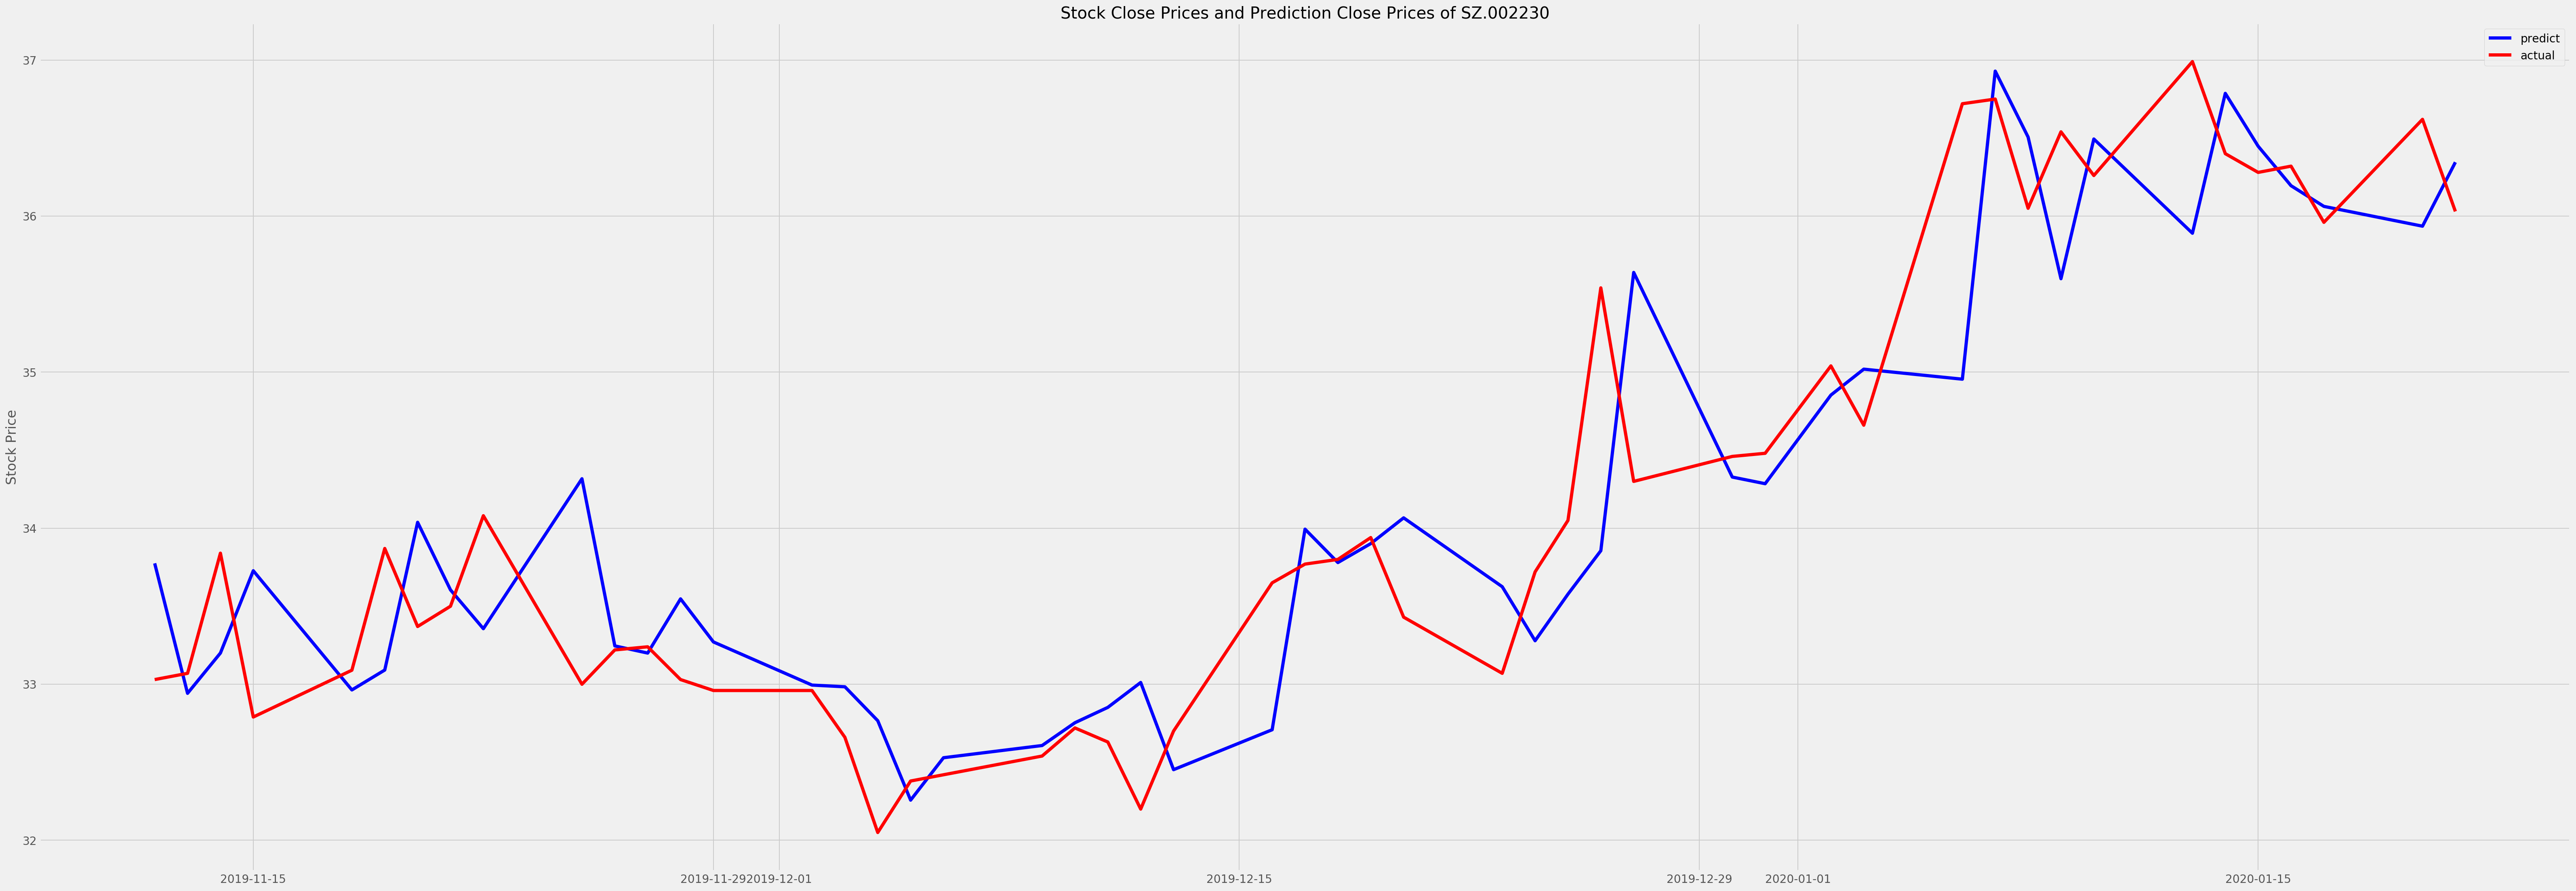

In [486]:
fig = plt.figure(figsize=(50,18))
# ax = fig.add_subplot(111)
# plt.xlabels=[x for x in news_dat]
plt.plot(pre,'b',label='predict')
plt.plot(to_y[203:],'r',label='actual')
# plt.xlabel('Months(2019-01——2020-01)')   #x轴标签
plt.ylabel('Stock Price')            #y轴标签
# year = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
# plt.xticks(np.arange(0,50,10)) #重新设置x轴间隔和刻度值
plt.title('Stock Close Prices and Prediction Close Prices of SZ.002230')
plt.legend()
plt.show()

In [476]:
# 计算模型在测试集上的MSE值
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,grid.predict(X_test))

0.05554218982485243

In [477]:
mean_squared_error(to_y[203:],pre)

0.4035875927163824

In [ ]:
writeToJson(X.iloc[round(len(X) * 0.7):round(len(X) * 0.7) + 10000, :])

In [ ]:
model = SVR(verbose = True)
model.fit(X.iloc[:round(len(X) * 0.7), :], y.iloc[:round(len(y) * 0.7)])

In [182]:
model.predict([[1, 1]])

array([1.5])

In [ ]:
# plt.plot(y_train,'lime',label='actual')
fig = plt.figure(figsize=(20,8))
plt.plot(pre,'b',label='predict')
plt.plot(y_train_reverse[100:],'r',label='actual',linewidth=2.5)
plt.legend()
plt.show()

In [ ]:
# import pandas as pd
# import csv

# for i in range(180,186):  # 爬取全部185页数据
#     url = 'http://s.askci.com/stock/a/?reportTime=2019-12-31&pageNum=%s' % (str(i))
#     tb = pd.read_html(url)[3] #经观察发现所需表格是网页中第4个表格，故为[3]
#     tb.to_csv(r'2019_12_31.csv', mode='a', encoding='utf_8_sig', header=1, index=0)
#     print('第'+str(i)+'页抓取完成')

In [ ]:
# import pysnowball as ball
# baj = ball.quotec('SZ002230')['data'][0]
# # baj
# data_kdxf = pd.DataFrame(baj, index=range(1, len(baj)+1))
# data_kdxf